## Combat A

In [1]:
import zeal.core as zc
import zeal.rotations as zr

p = zc.Player(weapon='torch', expertise=18)
p.print_properties()
t = zc.Target()
t.print_properties()
c = zc.CombatAnalyser(p, t)
c.rank_actions()

Player properties:
--                   AP = 3400
--          crit chance = 0.35
--               weapon = torch
--              arm pen = 0
--            expertise = 18
--  chance to be dodged = 0.02
Target properties:
--        base armor = 6200
--    modified armor = 1715
--             JotCr = True
--   expose weakness = 1200 agi


{'naked_swing': 0.7016955768520259,
 'sob_swing': 1.0,
 'soc_swing': 0.9572087619688003,
 'twist': 1.4221075092945836,
 'cs': 0.5691830871445493}

In [2]:
t2 = zc.Target(base_armor=8800, imp_ea=False)
t2.print_properties()
c2 = zc.CombatAnalyser(p, t2)
c2.rank_actions()

Target properties:
--        base armor = 8800
--    modified armor = 4790
--             JotCr = True
--   expose weakness = 1200 agi


{'naked_swing': 0.6220971565324761,
 'sob_swing': 1.0,
 'soc_swing': 0.9457905103892328,
 'twist': 1.534741075335278,
 'cs': 0.5046165199551642}

In [166]:
p.expertise = 12
c.rank_actions(normalise=False) 
#p.expertise = 5
#c.rank_actions()

{'naked_swing': 2155.263167787637,
 'sob_swing': 3054.556903873553,
 'soc_swing': 2926.3290907861624,
 'twist': 4320.193788037379,
 'cs': 1746.9616071472838}

In [735]:
import matplotlib.pyplot as plt

max_twist_window = 400
ms2sec = 1000.0

class RotationSimStates:
    """Class to Choose Rotation Sim Cooldowns"""
    cd_end_times = {}
    cd_values = {}
    cd_names = ["gcd","cs","judge", "cons", "melee", "exo"]  # Cooldown End Times
    times = {}
    time_names = ["current_time", "last_command_time"]
    seal = "Blood"
    weapon_speed = 3700
    debug = False
    disable_judgement_damage = False
    
    damage_values = {'naked_swing': 2155.263167787637, \
                     'sob_swing': 3054.556903873553, \
                     'soc_swing': 2926.3290907861624, \
                     'twist': 4320.193788037379, \
                     'cs': 1746.9616071472838, \
                     'cons': 1000.00, \
                     'exo': 900.00, \
                     'judge': 868.00}
    
    damage_total = 0
    combat_log = []

    # TODO add dynamic haste swing time updating
    # TODO track  mana usage and gains
    
    def _init_(self, weapon_speed, melee_haste_multiplier, spell_haste_multiplier, debug):
        self.weapon_speed = int(weapon_speed * melee_haste_multiplier)
        self.cd_values["spell_gcd"] = int(1500 * spell_haste_multiplier)
        self.cd_values["cs_gcd"] = 1500   
        self.cd_values["cs"] = 6000
        self.cd_values["judge"] = 8000
        self.cd_values["cons"] = 8000 
        self.cd_values["exo"] = 15000
        self.debug = debug
        self.damage_total = 0
        self.combat_log.clear()
              
        for name in self.cd_names:
            self.cd_end_times[name] = 0
        for name in self.time_names:
            self.times[name] = 0
        
        self.times["last_command_time"] = -max_twist_window - 1;
        
    def print_cds(self):
        cd_string = ""
        for key in self.cd_names:
            cd_delta_time = max(0, self.cd_end_times[key] - self.times["current_time"])
            cd_string = cd_string + " " + key + ":" + str(cd_delta_time / 1000.0)
        
        return str(cd_string).center(65)
          
    def melee_hit(self):
        is_twist = False
        ff_output_str = ""
        if self.seal == "Blood" and (self.cd_end_times["melee"] - self.times["last_command_time"]) <= max_twist_window:
            #print(self.times["last_command_time"] )
            #print(self.cd_end_times["melee"] )
            is_twist = True
            ff_output_str = ff_output_str + (str(self.cd_end_times["melee"]/ ms2sec) + " Auto_Attack_Twist").ljust(30)
        else:
            ff_output_str = ff_output_str + (str(self.cd_end_times["melee"]/ ms2sec) + " Auto_Attack_" + self.seal).ljust(30)
        
        self.times["current_time"] = self.cd_end_times["melee"]
        self.cd_end_times["melee"] += self.weapon_speed
        ff_output_str = ff_output_str + self.print_cds()
            
        if self.seal == "Blood":
            if is_twist:
                self.damage_total = self.damage_total + self.damage_values["twist"]
            else:
                self.damage_total = self.damage_total + self.damage_values["sob_swing"]
        elif self.seal == "Command":
            self.damage_total = self.damage_total + self.damage_values["soc_swing"]
        else:
            print("Seal Error")
        
        ff_output_str = ff_output_str + str(float(self.damage_total) * ms2sec / max(ms2sec, self.times["current_time"])).ljust(30)
        
        self.combat_log.append(ff_output_str)
        if self.debug:
            print(ff_output_str)
    
    def fast_forward(self, ff_time):
        while ff_time >= self.cd_end_times["melee"]:
            self.melee_hit()
        self.times["current_time"] = ff_time
    
    def fast_forward_check(self, ability_name, use_time):
        if self.is_seal(ability_name):
            ability_name = "gcd"
        if (self.times["current_time"] ==  self.cd_end_times["melee"]):
            self.fast_forward(self.times["current_time"])
        if (self.times["current_time"] < self.cd_end_times[ability_name] or \
            self.times["current_time"] < self.cd_end_times["gcd"]):
            self.fast_forward(max(self.cd_end_times["gcd"], \
                                  self.cd_end_times[ability_name], \
                                  use_time))
       
    def use_ability(self, ability_name, use_time):
        self.fast_forward_check(ability_name, use_time)
        self.update_cd(ability_name)
        self.record_damage(ability_name)
        
        ability_str = ""
        ability_str = ability_str + (str (self.times["current_time"] / ms2sec) + " " + ability_name).ljust(30)
        ability_str = ability_str + self.print_cds()
        ability_str = ability_str + (str(float(self.damage_total) * ms2sec / max(ms2sec, self.times["current_time"]))).ljust(30)
        
        self.combat_log.append(ability_str)
        if self.debug:
            print(ability_str)
        
    def record_damage(self, ability_name):
        if not self.is_seal(ability_name):
            self.damage_total = self.damage_total + self.damage_values[ability_name]
        else:
            self.swap_seal(ability_name)

    def swap_seal(self, ability_name):
        if self.seal == "Command" and ability_name == "Blood":
            self.times["last_command_time"] = self.times["current_time"]
        if self.seal == "Blood":
            if not self.disable_judgement_damage:
                if self.times["current_time"] >= self.cd_end_times["judge"]:
                    self.update_cd("judge")
                    self.record_damage("judge")
        self.seal = ability_name
       
    def is_seal(self, ability_name):
        if ability_name == "Blood" or ability_name == "Command":
            return True
        else:
            return False
        
    def update_cd(self, ability_name):
        if (ability_name != "Blood") and (ability_name != "Command"):
            self.cd_end_times[ability_name] = self.times["current_time"] + self.cd_values[ability_name]
        if ability_name != "judge":
            self.cd_end_times["gcd"] = self.times["current_time"] + self.get_gcd_value(ability_name)
        
    def get_gcd_value(self, ability_name):
        if ability_name == "cs":
            return self.cd_values["cs_gcd"]
        else:
            return self.cd_values["spell_gcd"]
              
    def get_current_time(self):
        return self.times["current_time"]
    
    def get_dps(self):
        return float(self.damage_total) * ms2sec / max(ms2sec, self.times["current_time"])
      
    #TODO refactor into an update damage function

        
class RotationStrategy:
    """Class to Choose Rotation Actions"""      
    run_time_end = 0
    prio_list = ["twist", "cs"]
    earliest_time = {}
    rot_sim_states: RotationSimStates
    debug = False
        
    # Rotation Strategies
    twist_to_completion = False
    early_command_setup = False
    twist_start_delta_cd = 600
    filler_delta_cd = 600  
    
    def _init_(self, rot_sim_states, debug):
        self.rot_sim_states = rot_sim_states
        self.debug = debug
    
    def get_next_action(self):
        self.update_cd_list()
        return self.fcfs()
    
    def update_cd_list(self):
        self.update_earliest_cs()
     
        melee_cd = self.get_end_cd("melee")
        command_gcd = self.rot_sim_states.get_gcd_value("Command")
        twist_execution_time = 0
        
        
        if self.rot_sim_states.seal == "Blood":
            self.earliest_time["twist"] = max(self.get_end_cd("gcd"), \
                                              melee_cd - max_twist_window - command_gcd)
            if self.debug:
                print (self.get_end_cd("gcd") + self.rot_sim_states.get_gcd_value("Blood"))
                print (self.get_end_cd("melee") - 400)
            twist_execution_time = self.earliest_time["twist"] + command_gcd
        elif  self.rot_sim_states.seal == "Command":
            self.earliest_time["twist"] = max(self.get_end_cd("gcd"), \
                                              melee_cd - max_twist_window)
            if self.debug:
                print (self.get_end_cd("gcd"))
                print (self.get_end_cd("melee") - max_twist_window)
            twist_execution_time = self.earliest_time["twist"]
        else:
            print("Something Went Wrong")
            exit()
               
        if self.rot_sim_states.seal == "Command" and self.twist_to_completion:
            self.earliest_time["cs"] = self.earliest_time["twist"] + 100000
                 
        self.shift_twist_swing(twist_execution_time, melee_cd, command_gcd, 2)       
                     
        if self.rot_sim_states.seal == "Blood" and (self.earliest_time["cs"] - self.earliest_time["twist"]) < self.twist_start_delta_cd:
            self.earliest_time["twist"] = self.earliest_time["twist"] + 100000
                
        self.update_earliest_cons()
        self.update_earliest_exo()
        
        if self.early_command_setup:
            self.early_command_setup(melee_cd)
        
    def early_command_setup(self, melee_cd):
        min_earliest_time = self.earliest_time["cs"]
        for ability in self.prio_list:
            if ability != "twist":
                min_earliest_time = min(min_earliest_time, self.earliest_time[ability])
                
        if self.earliest_time["twist"] < min_earliest_time:
            if self.rot_sim_states.seal == "Blood" and \
               (min_earliest_time - self.get_end_cd("gcd")) > 1500:
                self.earliest_time["twist"] = self.get_end_cd("gcd")
        
    def shift_twist_swing(self, twist_execution_time, melee_cd, command_gcd, max_command_hits):
        """Delay twist if impossible to hit next swing window"""
        #max_command_hits is max amount of time command might hit before the twist happens
        # It will only happen at fast swing speeds
            
        if twist_execution_time >= melee_cd + max_command_hits * self.rot_sim_states.weapon_speed:
            if self.debug:
                print("Twist exceution Time, Melee to Soon")
                print(twist_execution_time)
                print(melee_cd)
            self.earliest_time["twist"] = melee_cd + (max_command_hits + 1) *self.rot_sim_states.weapon_speed - max_twist_window
            if self.rot_sim_states.seal == "Blood":
                # Go from Twist time to Setup Twist Time
                self.earliest_time["twist"] = self.earliest_time["twist"] - command_gcd
        elif max_command_hits > 0:
            self.shift_twist_swing(twist_execution_time, melee_cd, command_gcd, max_command_hits - 1)
        
    def update_earliest_cons(self):
        self.update_earliest_filler("cons")
            
    def update_earliest_exo(self):
        self.update_earliest_filler("exo")
 
    def update_earliest_filler(self, filler_name):
        self.earliest_time[filler_name] = max(self.get_end_cd(filler_name) , \
                                       self.get_end_cd("gcd"))
        
        if self.earliest_time["cs"] -  self.filler_delta_cd < self.earliest_time[filler_name]:
            self.earliest_time[filler_name] = self.earliest_time[filler_name] + 100000
            
     
    def update_earliest_cs(self):
        self.earliest_time["cs"] = max(self.get_end_cd("cs") , \
                                       self.get_end_cd("gcd"))
        
    def get_end_cd(self, ability_name):
        return self.rot_sim_states.cd_end_times[ability_name]
          
    def get_twist_seal(self):
        if self.rot_sim_states.seal == "Blood":
            return "Command"
        elif  self.rot_sim_states.seal == "Command":
            return "Blood"
        else:
            print("Error No Seal active")
            exit()
    
    def fcfs(self):
        fcfs_skill = self.prio_list[0]
        fcfs_cd =self.earliest_time[fcfs_skill]
        
        for skill in self.prio_list:
            if self.earliest_time[skill] < fcfs_cd:
                fcfs_skill = skill
                fcfs_cd = self.earliest_time[skill]
        
        if fcfs_skill == "twist":
            fcfs_skill = self.get_twist_seal()

        return fcfs_skill, fcfs_cd
                
class RotationSim:
    """Class to Choose Rotation Actions"""      
    run_time_end: int
    rot_sim_strat: RotationStrategy
    rot_sim_states: RotationSimStates
    debug = False
    
    def _init_(self, rot_sim_strat, rot_sim_states, run_time_end, debug): 
        self.run_time_end  = run_time_end
        self.rot_sim_strat = rot_sim_strat
        self.rot_sim_states = rot_sim_states
        self.debug = debug
        
    def run_sim(self):
        while self.get_current_time() < self.run_time_end:
            next_skill, next_time = rot_sim_strat.get_next_action()
            if self.debug:
                print(self.get_current_time_str() + " Going to " + next_skill + " at " + str(next_time / 1000.0))
            rot_sim_states.use_ability(next_skill, next_time)
    
    def get_current_time(self):
         return self.rot_sim_states.get_current_time()
        
    def get_current_time_str(self):
         return str(self.get_current_time() / ms2sec)
        
    def get_dps(self):
        return self.rot_sim_states.get_dps()
         
def plot_theoretical_max(twist_ratio, cs_avg_cd, melee_haste):
    weapon_speeds = []
    rotation_dps = []
    rotation_names.append("Theoretical Max " + str(twist_ratio) + " Twist (No Judge)")
    for weapon_speed in reversed(range(1000, 3800, 25)):
        weapon_speeds.append(weapon_speed)
        
        cs_dps        = rot_sim_states.damage_values["cs"] / cs_avg_cd
        blood_hit_dps = (1 - twist_ratio) * rot_sim_states.damage_values["sob_swing"] / (weapon_speed * melee_haste / ms2sec)
        twist_dps     = twist_ratio * rot_sim_states.damage_values["twist"] / (weapon_speed * melee_haste  / ms2sec)
        rotation_dps.append(cs_dps + blood_hit_dps + twist_dps)
        
    plt.plot(weapon_speeds, rotation_dps, alpha=0.3) 
      
def plot_rotation(rot_name, prio, twist_to_completion, cs_delay, melee_haste_multiplier, spell_haste_multiplier):
    weapon_speeds, rotation_dps = run_rotation(rot_name, prio, twist_to_completion, cs_delay, melee_haste_multiplier, spell_haste_multiplier)
    plt.plot(weapon_speeds, rotation_dps)
    
def run_rotation(rot_name, prio, twist_to_completion, cs_delay, melee_haste_multiplier, spell_haste_multiplier):
    weapon_speeds = []
    rotation_dps = []
    rotation_names.append(rot_name + " cs_delay: " + str(cs_delay))
    rot_sim_strat.prio_list = prio
    rot_sim_strat.twist_to_completion = twist_to_completion
    rot_sim_strat.twist_start_delta_cd = cs_delay

    for weapon_speed in reversed(range(1000, 3800, 25)):
        rot_sim_states._init_(weapon_speed, melee_haste_multiplier, spell_haste_multiplier, False)
        rot_sim.run_sim()
        weapon_speeds.append(weapon_speed)
        rotation_dps.append(rot_sim.get_dps())
        
    return weapon_speeds, rotation_dps
    
def plot_known_rotation(rot_name, rot_ability_count, start_speed, end_speed):
    weapon_speeds = []
    rotation_dps = []
    twist_ratio = rot_ability_count[0] / rot_ability_count[2]
    
    rotation_names.append("Known Rotation " + rot_name)
    
    judge_dps = 0.0
                      
    for weapon_speed in range(end_speed, start_speed, 25):
        if "Judge" in rot_name:
            judge_dps = rot_sim_states.damage_values["judge"] / ((weapon_speed/ ms2sec) * rot_ability_count[2])
        weapon_speeds.append(weapon_speed)
        cs_avg_cd =  (rot_ability_count[2] * weapon_speed / ms2sec) / rot_ability_count[1] 
        cs_dps = rot_sim_states.damage_values["cs"] / cs_avg_cd
        blood_hit_dps = (1 - twist_ratio) * rot_sim_states.damage_values["sob_swing"] / (weapon_speed / ms2sec)
        twist_dps = twist_ratio * rot_sim_states.damage_values["twist"] / (weapon_speed / ms2sec)
        rotation_dps.append(cs_dps + blood_hit_dps + twist_dps + judge_dps)

    plt.plot(weapon_speeds, rotation_dps, alpha=1) 
    
def plot_known_rotations():
    plot_known_rotation("1/2 Rotation",   [1,1,2], 3800, 3000)
    plot_known_rotation("3/2/5 Rotation", [3,2,5], 3000, 2800)
    plot_known_rotation("2/2/5 Rotation", [2,2,5], 2700, 2400)
    plot_known_rotation("1/1/3 Rotation with Judge", [1,1,3], 2600, 2500)
    plot_known_rotation("1/1/3 Rotation", [1,1,3], 2300, 2000)
    plot_known_rotation("1/1/4 Rotation", [1,1,4], 1800, 1600)   # Verify if possible
    #plot_known_rotation("2/1/5 Rotation", [2,1,5], 1350, 1250)   #Should Use COmmand?
    plot_known_rotation("2/1/8 Rotation", [2,1,8], 1250, 1000)   #Should Use 1 COmmand?
    plot_known_rotation("1/1/4 Rotation", [1,1,4], 1600, 1500)   # 2/5 might be better till 1.5sec at least
    
def plot_labeling(include_legend = True):
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.xlabel('Hasted Weapon Speed')
    plt.ylabel('Rotation DPS')
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt.minorticks_on()
    plt.xlim(max(weapon_speeds), min(weapon_speeds))
    plt.ylim(1000, 4000)
    if include_legend:
        plt.legend(rotation_names)
    plt.show()

def find_rotation_from_log(combat_log, ignore_filler):
    for i in range(100,len(combat_log)):                  #TODO start rotation from Twist or CS  (not a big deal)
        for j in range(i+1, len(combat_log)):
            if is_same_cds(combat_log[i], combat_log[j], ignore_filler):
                print("Found Rotation from :" + combat_log[i].split()[0] + " to " + combat_log[j].split()[0])
                for k in range(i, j+1):
                    print(combat_log[k]) 
                return
            
def is_same_cds(combat_log_line_a, combat_log_line_b, ignore_filler):
    split_line_a = combat_log_line_a.split()
    split_line_b = combat_log_line_b.split()
    if not ignore_filler:
        if split_line_a[2:7] == split_line_b[2:7]:
            print("Found Rotation from :" + split_line_a[0] + " to " + split_line_b[0])
            return True
    else: 
        match = True
        for i in range(2,8):
            if ("cons" not in split_line_a[i]) and ("exo" not in split_line_a[i]):
                if split_line_a[i] != split_line_b[i]:
                    match = False
                    return False
        return match
    
def plot_theoretical_max_rotations():
    plot_theoretical_max(0.5,   6,  melee_haste)
    plot_theoretical_max(0.4,   6,  melee_haste)
    plot_theoretical_max(0.333, 6,  melee_haste)
    plot_theoretical_max(0.25,  6,  melee_haste)
    plot_theoretical_max(0.25,  8,  melee_haste)
    
def plot_bloodlust_increase(rot_name, prio, twist_to_completion, cs_delay, melee_haste_multiplier, spell_haste_multiplier):
    weapon_speeds = []
    rotation_dps = []
    rotation_dps_bloodlust = []
    rotation_names.append(rot_name + " cs_delay: " + str(cs_delay))
    rot_sim_strat.prio_list = prio
    rot_sim_strat.twist_to_completion = twist_to_completion
    rot_sim_strat.twist_start_delta_cd = cs_delay

    for weapon_speed in reversed(range(1000, 3800, 25)):
        rot_sim_states._init_(weapon_speed, melee_haste_multiplier, spell_haste_multiplier, False)
        rot_sim.run_sim()
        weapon_speeds.append(weapon_speed)
        rotation_dps.append(rot_sim.get_dps())
        
    for weapon_speed in reversed(range(1000, 3800, 25)):
        rot_sim_states._init_(weapon_speed, melee_haste_multiplier * 0.769, spell_haste_multiplier * 0.769, False)
        rot_sim.run_sim()
        rotation_dps_bloodlust.append(rot_sim.get_dps())
        ratio = [i / j for i, j in zip(rotation_dps_bloodlust, rotation_dps)]
    plt.plot(weapon_speeds, ratio)
    plt.xlim(max(weapon_speeds), min(weapon_speeds))
    plt.ylim(0.0, 2.0)
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt.minorticks_on()
    
def plot_max_cs_delay_dps(rot_name, prio, twist_to_completion, melee_haste_multiplier, spell_haste_multiplier):
    dps_values = []
    max_dps = []
    max_dps_cs_delay = []
    weapon_speeds = []
    for cs_delay in range(0, 3500, 50):
        weapon_speeds, rotation_dps = run_rotation(rot_name, prio, twist_to_completion, cs_delay, melee_haste_multiplier, spell_haste_multiplier)
        if len(max_dps) == 0:
            max_dps = rotation_dps
            for weapon_speed in weapon_speeds:
                max_dps_cs_delay.append(cs_delay)
        else:
            for i in range(0, len(weapon_speeds)):
                if max_dps[i] < rotation_dps[i] * 1.02: # Within 1%
                    max_dps[i] = rotation_dps[i]
                    max_dps_cs_delay[i] = cs_delay
                    
    # Check if Statisticall Significant vs 0 Delay
    weapon_speeds, rotation_dps = run_rotation(rot_name, prio, twist_to_completion, 0, melee_haste_multiplier, spell_haste_multiplier)
    for i in range(0, len(weapon_speeds)):
        if max_dps[i] < rotation_dps[i] * 1.01: # Within 1%
            max_dps[i] = rotation_dps[i]
            max_dps_cs_delay[i] = 0    
                   
    fig, axs = plt.subplots(2)
    fig.suptitle('Vertically stacked subplots')
    axs[0].plot(weapon_speeds, max_dps)
    axs[0].set_xlim(max(weapon_speeds), min(weapon_speeds))
    axs[0].set_ylim(1000, 4000)
    axs[1].plot(weapon_speeds, max_dps_cs_delay)
    axs[1].set_xlim(max(weapon_speeds), min(weapon_speeds))
    axs[1].set_ylim(0, 3500)
    #plt.plot(weapon_speeds, max_dps)
    plt.show()
             
def plot_all_cs_delay_dps(rot_name, prio, twist_to_completion, melee_haste_multiplier, spell_haste_multiplier):
    for cs_delay in range(-3000, 3000, 50):
        plot_rotation(rot_name, prio, twist_to_completion, cs_delay, melee_haste_multiplier, spell_haste_multiplier)
        
# TODO CS uptime, Twist ratio, average fillers, rotation analyzer, DPM, MPS
# TODO plot CS delay distribution +avg
# Rotation identifier  (In progress)
# plot avg filler uptime
# plot speed to avoid using spell haste delta
# plot speed to avoid twist window shrink, avoid switching seal on Melee hit synced
# plot GCD usage percent
# plot blood/command/twist percent
# TODO Early Judgement

# TODO - Not sure if Needed
# token for don't command if CS will interupt twist
# token for command and cs, ride command, then twist
# token for command, twist, then delayed CS


# Ideas:
# randomize initial CD values to potentially discover new rotations

         

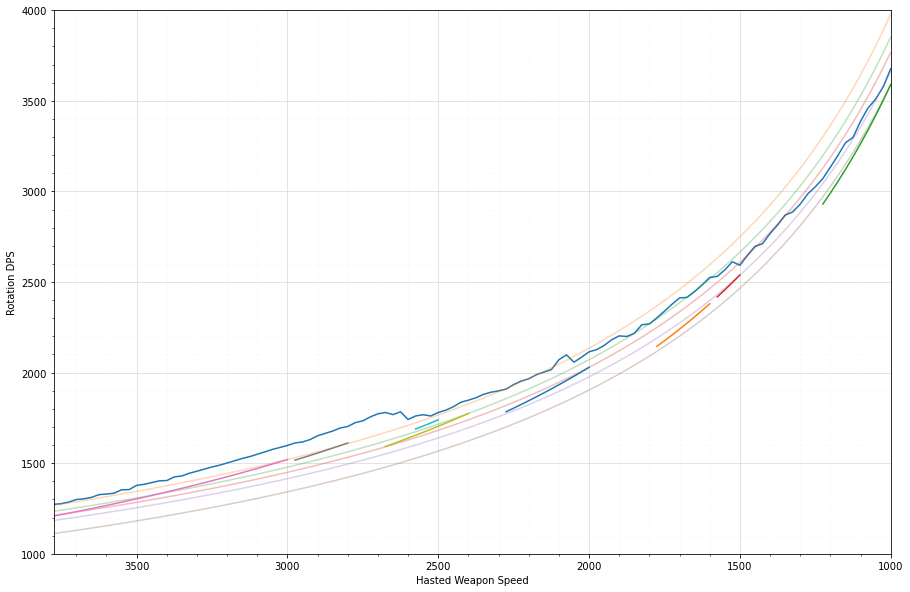

In [737]:
sim_run_time_end = 400000 # Long Runtime to let Rotation find a stable cycle  
rotation_names = []
rot_sim_states = RotationSimStates()
rot_sim_states.disable_judgement_damage = False
rot_sim_states.damage_values = {'naked_swing': 2155.263167787637, \
                                'sob_swing': 3054.556903873553, \
                                'soc_swing': 2926.3290907861624, \
                                'twist': 4320.193788037379, \
                                'cs': 1746.9616071472838, \
                                'cons': 1000.00, \
                                'exo': 900.00, \
                                'judge': 868.00}


rot_sim_strat = RotationStrategy()
rot_sim_strat._init_(rot_sim_states, False)
rot_sim = RotationSim()
rot_sim._init_(rot_sim_strat, rot_sim_states, sim_run_time_end, False)
rot_sim_strat.early_command_setup = False

bloodlust = False
spell_haste = 1.0  # Lower is Faster
melee_haste = 1.0  # Lower is Faster
if bloodlust:
    spell_haste = 0.769  # Lower is Faster
    melee_haste = 0.769  # Lower is Faster

#for cs_delay in range(-2500, 2500, 50):
#    plot_rotation("No Filler", ["cs", "twist", "cons", "exo"], True, cs_delay, melee_haste,  spell_haste)
#    plot_rotation("No Filler", ["twist", "cs", "cons", "exo"], True, cs_delay, melee_haste,  spell_haste)
  
#plot_max_cs_delay_dps("No Filler", ["twist", "cs"], True, melee_haste, spell_haste)
#plot_max_cs_delay_dps("No Filler", ["cs", "twist"], True, melee_haste, spell_haste)

#plot_rotation("No Filler", ["twist", "cs"], True, 0, melee_haste, spell_haste)
plot_rotation("No Filler", ["twist", "cs"], True, 600, melee_haste, spell_haste)
plot_theoretical_max_rotations()
plot_known_rotations()

#plot_rotation("Full Rotation", ["twist", "cs", "cons", "exo"], True,  600, melee_haste,  spell_haste)

plot_labeling(include_legend = False)






In [733]:
rot_sim.debug = True
rot_sim_strat._init_(rot_sim_states, True)
#rot_sim_strat.prio_list = ["twist", "cs", "cons", "exo"]
rot_sim_strat.prio_list = ["twist", "cs"]
#rot_sim_strat.prio_list = ["cs", "twist"]
rot_sim_strat.twist_to_completion = True
rot_sim_strat.twist_start_delta_cd = 600
rot_sim_states._init_(2100, 1.0, 1.0, True)
rot_sim.run_sim()

ignore_filler_cd = False
find_rotation_from_log(rot_sim_states.combat_log, ignore_filler_cd)

1500
-400
Twist exceution Time, Melee to Soon
1500
0
0.0 Going to cs at 0.0
0.0 Auto_Attack_Blood                 gcd:0.0 cs:0.0 judge:0.0 cons:0.0 melee:2.1 exo:0.0      3054.556903873553             
0.0 cs                                gcd:1.5 cs:6.0 judge:0.0 cons:0.0 melee:2.1 exo:0.0      4801.518511020837             
3000
1700
Twist exceution Time, Melee to Soon
3000
2100
0.0 Going to Command at 2.3
2.1 Auto_Attack_Blood                 gcd:0.0 cs:3.9 judge:0.0 cons:0.0 melee:2.1 exo:0.0      3740.9882928068523            
2.3 Command                           gcd:1.5 cs:3.7 judge:8.0 cons:0.0 melee:1.9 exo:0.0      3793.0762673453864            
3800
3800
2.3 Going to Blood at 3.8
3.8 Blood                             gcd:1.5 cs:2.2 judge:6.5 cons:0.0 melee:0.4 exo:0.0      2295.8093197090498            
6800
3800
Twist exceution Time, Melee to Soon
6800
4200
3.8 Going to cs at 6.0
4.2 Auto_Attack_Twist                 gcd:1.1 cs:1.8 judge:6.1 cons:0.0 melee:2.1 exo:0.0      

1500
-400
Twist exceution Time, Melee to Soon
1500
0
0.0 Going to cs at 0.0
3000
3375
0.0 Going to cons at 1.5
4500
3375
Twist exceution Time, Melee to Soon
4500
3775
1.5 Going to exo at 3.0
6000
3375
Twist exceution Time, Melee to Soon
6000
3775
3.0 Going to cs at 6.0
9000
7150
Twist exceution Time, Melee to Soon
9000
7550
6.0 Going to Command at 9.425
10925
10925
9.425 Going to Blood at 10.925
13925
10925
Twist exceution Time, Melee to Soon
13925
11325
10.925 Going to cs at 12.425
15425
14700
Twist exceution Time, Melee to Soon
15425
15100
12.425 Going to cons at 13.925
16925
14700
Twist exceution Time, Melee to Soon
16925
15100
13.925 Going to Command at 16.975
18475
18475
16.975 Going to Blood at 18.475
21475
18475
Twist exceution Time, Melee to Soon
21475
18875
18.475 Going to cs at 19.975
22975
22250
Twist exceution Time, Melee to Soon
22975
22650
19.975 Going to exo at 21.475
24475
22250
Twist exceution Time, Melee to Soon
24475
22650
21.475 Going to cons at 22.975
25975
26025
2

Twist exceution Time, Melee to Soon
196700
196100
193.7 Going to cs at 198.2
201200
199400
Twist exceution Time, Melee to Soon
201200
199800
198.2 Going to cons at 199.7
202700
199400
Twist exceution Time, Melee to Soon
202700
199800
199.7 Going to Command at 201.6
203100
203100
201.6 Going to Blood at 203.1
206100
203100
Twist exceution Time, Melee to Soon
206100
203500
203.1 Going to cs at 204.6
207600
206800
Twist exceution Time, Melee to Soon
207600
207200
204.6 Going to cons at 207.7
210700
210500
207.7 Going to Command at 209.2
210700
210500
209.2 Going to Blood at 210.7
213700
210500
Twist exceution Time, Melee to Soon
213700
210900
210.7 Going to cs at 212.2
215200
214200
Twist exceution Time, Melee to Soon
215200
214600
212.2 Going to exo at 213.7
216700
214200
Twist exceution Time, Melee to Soon
216700
214600
213.7 Going to cons at 215.7
218700
217900
Twist exceution Time, Melee to Soon
218700
218300
215.7 Going to cs at 218.2
221200
217900
Twist exceution Time, Melee to Soon

26.3 Going to cs at 27.8
30800
28400
Twist exceution Time, Melee to Soon
30800
28800
27.8 Going to Command at 30.5
32000
32000
30.5 Going to Blood at 32.0
35000
32000
Twist exceution Time, Melee to Soon
35000
32400
32.0 Going to cs at 33.8
36800
35600
Twist exceution Time, Melee to Soon
36800
36000
33.8 Going to cons at 35.3
38300
35600
Twist exceution Time, Melee to Soon
38300
36000
35.3 Going to exo at 36.8
39800
39200
Twist exceution Time, Melee to Soon
39800
39600
36.8 Going to cs at 39.8
42800
42800
39.8 Going to Command at 41.3
42800
42800
41.3 Going to Blood at 42.8
45800
42800
Twist exceution Time, Melee to Soon
45800
43200
42.8 Going to cons at 44.3
47300
46400
Twist exceution Time, Melee to Soon
47300
46800
44.3 Going to cs at 45.8
48800
46400
Twist exceution Time, Melee to Soon
48800
46800
45.8 Going to Command at 48.5
50000
50000
48.5 Going to Blood at 50.0
53000
50000
Twist exceution Time, Melee to Soon
53000
50400
50.0 Going to cs at 51.8
54800
53600
Twist exceution Time,

281375
278075
Twist exceution Time, Melee to Soon
281375
278475
278.375 Going to exo at 279.875
282875
281600
Twist exceution Time, Melee to Soon
282875
282000
279.875 Going to cs at 282.875
285875
285125
Twist exceution Time, Melee to Soon
285875
285525
282.875 Going to cons at 286.375
289375
288650
Twist exceution Time, Melee to Soon
289375
289050
286.375 Going to cs at 288.875
291875
288650
Twist exceution Time, Melee to Soon
291875
289050
288.875 Going to Command at 290.675
292175
292175
290.675 Going to Blood at 292.175
295175
292175
Twist exceution Time, Melee to Soon
295175
292575
292.175 Going to Command at 294.2
295700
295700
294.2 Going to Blood at 295.7
298700
295700
Twist exceution Time, Melee to Soon
298700
296100
295.7 Going to cs at 297.2
300200
299225
Twist exceution Time, Melee to Soon
300200
299625
297.2 Going to cons at 298.7
301700
299225
Twist exceution Time, Melee to Soon
301700
299625
298.7 Going to exo at 300.2
303200
302750
Twist exceution Time, Melee to Soon
3

122075
119475
Twist exceution Time, Melee to Soon
122075
119875
119.075 Going to cons at 121.075
124075
122900
Twist exceution Time, Melee to Soon
124075
123300
121.075 Going to cs at 123.575
126575
126325
123.575 Going to Command at 125.075
126575
126325
125.075 Going to Blood at 126.575
129575
126325
Twist exceution Time, Melee to Soon
129575
126725
126.575 Going to Command at 128.25
129750
129750
128.25 Going to Blood at 129.75
132750
129750
Twist exceution Time, Melee to Soon
132750
130150
129.75 Going to cs at 131.25
134250
133175
Twist exceution Time, Melee to Soon
134250
133575
131.25 Going to cons at 132.75
135750
133175
Twist exceution Time, Melee to Soon
135750
133575
132.75 Going to exo at 134.25
137250
136600
Twist exceution Time, Melee to Soon
137250
137000
134.25 Going to cs at 137.25
140250
140025
137.25 Going to Command at 138.75
140250
140025
138.75 Going to Blood at 140.25
143250
140025
Twist exceution Time, Melee to Soon
143250
140425
140.25 Going to cons at 141.75
1

Twist exceution Time, Melee to Soon
258350
257950
255.35 Going to cs at 258.35
261350
260900
Twist exceution Time, Melee to Soon
261350
261300
258.35 Going to cons at 261.85
264850
264250
Twist exceution Time, Melee to Soon
264850
264650
261.85 Going to cs at 264.35
267350
264250
Twist exceution Time, Melee to Soon
267350
264650
264.35 Going to Command at 266.1
267600
267600
266.1 Going to Blood at 267.6
270600
267600
Twist exceution Time, Melee to Soon
270600
268000
267.6 Going to Command at 269.45
270950
270950
269.45 Going to Blood at 270.95
273950
270950
Twist exceution Time, Melee to Soon
273950
271350
270.95 Going to cs at 272.45
275450
274300
Twist exceution Time, Melee to Soon
275450
274700
272.45 Going to cons at 273.95
276950
274300
Twist exceution Time, Melee to Soon
276950
274700
273.95 Going to exo at 275.45
278450
277650
Twist exceution Time, Melee to Soon
278450
278050
275.45 Going to cs at 278.45
281450
281000
Twist exceution Time, Melee to Soon
281450
281400
278.45 Goi

188100
Twist exceution Time, Melee to Soon
189350
188500
186.35 Going to cons at 187.85
190850
188100
Twist exceution Time, Melee to Soon
190850
188500
187.85 Going to Command at 189.85
191350
191350
189.85 Going to Blood at 191.35
194350
191350
Twist exceution Time, Melee to Soon
194350
191750
191.35 Going to cs at 192.85
195850
194600
Twist exceution Time, Melee to Soon
195850
195000
192.85 Going to exo at 194.35
197350
194600
Twist exceution Time, Melee to Soon
197350
195000
194.35 Going to cons at 195.85
198850
197850
Twist exceution Time, Melee to Soon
198850
198250
195.85 Going to cs at 198.85
201850
201100
Twist exceution Time, Melee to Soon
201850
201500
198.85 Going to Command at 202.85
204350
204350
202.85 Going to Blood at 204.35
207350
204350
Twist exceution Time, Melee to Soon
207350
204750
204.35 Going to cs at 205.85
208850
207600
Twist exceution Time, Melee to Soon
208850
208000
205.85 Going to cons at 207.35
210350
207600
Twist exceution Time, Melee to Soon
210350
2080

Twist exceution Time, Melee to Soon
127000
126000
124.0 Going to cs at 126.8
129800
128750
Twist exceution Time, Melee to Soon
129800
129150
126.8 Going to Command at 130.4
131900
131900
130.4 Going to Blood at 131.9
134900
131900
Twist exceution Time, Melee to Soon
134900
132300
131.9 Going to cs at 133.4
136400
135050
Twist exceution Time, Melee to Soon
136400
135450
133.4 Going to cons at 134.9
137900
135050
Twist exceution Time, Melee to Soon
137900
135450
134.9 Going to Command at 136.7
138200
138200
136.7 Going to Blood at 138.2
141200
138200
Twist exceution Time, Melee to Soon
141200
138600
138.2 Going to cs at 139.7
142700
141350
Twist exceution Time, Melee to Soon
142700
141750
139.7 Going to exo at 141.2
144200
141350
Twist exceution Time, Melee to Soon
144200
141750
141.2 Going to cons at 142.9
145900
144500
Twist exceution Time, Melee to Soon
145900
144900
142.9 Going to cs at 145.7
148700
147650
Twist exceution Time, Melee to Soon
148700
148050
145.7 Going to Command at 14

31.85 Going to cons at 33.35
36350
33425
Twist exceution Time, Melee to Soon
36350
33825
33.35 Going to exo at 34.85
37850
36500
Twist exceution Time, Melee to Soon
37850
36900
34.85 Going to cs at 37.85
40850
39575
Twist exceution Time, Melee to Soon
40850
39975
37.85 Going to Command at 41.15
42650
42650
41.15 Going to Blood at 42.65
45650
42650
Twist exceution Time, Melee to Soon
45650
43050
42.65 Going to cs at 44.15
47150
45725
Twist exceution Time, Melee to Soon
47150
46125
44.15 Going to cons at 45.65
48650
45725
Twist exceution Time, Melee to Soon
48650
46125
45.65 Going to Command at 47.3
48800
48800
47.3 Going to Blood at 48.8
51800
48800
Twist exceution Time, Melee to Soon
51800
49200
48.8 Going to cs at 50.3
53300
51875
Twist exceution Time, Melee to Soon
53300
52275
50.3 Going to exo at 51.8
54800
51875
Twist exceution Time, Melee to Soon
54800
52275
51.8 Going to Command at 53.45
54950
54950
53.45 Going to Blood at 54.95
57950
54950
Twist exceution Time, Melee to Soon
579

197600
196.1 Going to Blood at 197.6
200600
197600
Twist exceution Time, Melee to Soon
200600
198000
197.6 Going to cs at 199.1
202100
200600
Twist exceution Time, Melee to Soon
202100
201000
199.1 Going to cons at 200.6
203600
200600
Twist exceution Time, Melee to Soon
203600
201000
200.6 Going to Command at 202.1
203600
203600
202.1 Going to Blood at 203.6
206600
203600
Twist exceution Time, Melee to Soon
206600
204000
203.6 Going to cs at 205.1
208100
206600
Twist exceution Time, Melee to Soon
208100
207000
205.1 Going to Command at 208.1
209600
209600
208.1 Going to Blood at 209.6
212600
209600
Twist exceution Time, Melee to Soon
212600
210000
209.6 Going to cs at 211.1
214100
212600
Twist exceution Time, Melee to Soon
214100
213000
211.1 Going to cons at 212.6
215600
212600
Twist exceution Time, Melee to Soon
215600
213000
212.6 Going to Command at 214.1
215600
215600
214.1 Going to Blood at 215.6
218600
215600
Twist exceution Time, Melee to Soon
218600
216000
215.6 Going to cs at

300875
Twist exceution Time, Melee to Soon
302450
301275
299.45 Going to cons at 300.95
303950
300875
Twist exceution Time, Melee to Soon
303950
301275
300.95 Going to Command at 302.3
303950
303800
302.45 Going to Blood at 303.95
306950
303800
Twist exceution Time, Melee to Soon
306950
304200
303.95 Going to cs at 305.45
308450
306725
Twist exceution Time, Melee to Soon
308450
307125
305.45 Going to exo at 306.95
309950
306725
Twist exceution Time, Melee to Soon
309950
307125
306.95 Going to Command at 308.15
309950
309650
308.45 Going to Blood at 309.95
312950
309650
Twist exceution Time, Melee to Soon
312950
310050
309.95 Going to cs at 311.45
314450
312575
Twist exceution Time, Melee to Soon
314450
312975
311.45 Going to cons at 312.95
315950
312575
Twist exceution Time, Melee to Soon
315950
312975
312.95 Going to cs at 317.45
320450
318425
Twist exceution Time, Melee to Soon
320450
318825
317.45 Going to Command at 319.85
321350
321350
319.85 Going to Blood at 321.35
324350
321350

Twist exceution Time, Melee to Soon
392000
390450
389.0 Going to Command at 391.4
392900
392900
391.4 Going to Blood at 392.9
395900
392900
Twist exceution Time, Melee to Soon
395900
393300
392.9 Going to cs at 394.4
397400
395750
Twist exceution Time, Melee to Soon
397400
396150
394.4 Going to cons at 395.9
398900
395750
Twist exceution Time, Melee to Soon
398900
396150
395.9 Going to Command at 397.1
398900
398600
397.4 Going to Blood at 398.9
401900
398600
Twist exceution Time, Melee to Soon
401900
399000
398.9 Going to cs at 400.4
1500
-400
Twist exceution Time, Melee to Soon
1500
0
0.0 Going to cs at 0.0
3000
2425
Twist exceution Time, Melee to Soon
3000
2825
0.0 Going to cons at 1.5
4500
2425
Twist exceution Time, Melee to Soon
4500
2825
1.5 Going to exo at 3.0
6000
5250
Twist exceution Time, Melee to Soon
6000
5650
3.0 Going to cs at 6.0
9000
8075
Twist exceution Time, Melee to Soon
9000
8475
6.0 Going to Command at 9.4
10900
10900
9.4 Going to Blood at 10.9
13900
10900
Twist ex

Twist exceution Time, Melee to Soon
134850
132000
131.85 Going to exo at 133.35
136350
134350
Twist exceution Time, Melee to Soon
136350
134750
133.35 Going to Command at 135.6
137100
137100
135.6 Going to Blood at 137.1
140100
137100
Twist exceution Time, Melee to Soon
140100
137500
137.1 Going to cs at 138.6
141600
139850
Twist exceution Time, Melee to Soon
141600
140250
138.6 Going to cons at 140.1
143100
139850
Twist exceution Time, Melee to Soon
143100
140250
140.1 Going to Command at 143.85
145350
145350
143.85 Going to Blood at 145.35
148350
145350
Twist exceution Time, Melee to Soon
148350
145750
145.35 Going to cs at 146.85
149850
148100
Twist exceution Time, Melee to Soon
149850
148500
146.85 Going to cons at 148.35
151350
148100
Twist exceution Time, Melee to Soon
151350
148500
148.35 Going to exo at 149.85
152850
150850
Twist exceution Time, Melee to Soon
152850
151250
149.85 Going to Command at 152.1
153600
153600
152.1 Going to Blood at 153.6
156600
153600
Twist exceution

288825
285825
Twist exceution Time, Melee to Soon
288825
286225
285.825 Going to cs at 287.325
290325
288500
Twist exceution Time, Melee to Soon
290325
288900
287.325 Going to cons at 288.825
291825
288500
Twist exceution Time, Melee to Soon
291825
288900
288.825 Going to exo at 290.325
293325
291175
Twist exceution Time, Melee to Soon
293325
291575
290.325 Going to Command at 292.35
293850
293850
292.35 Going to Blood at 293.85
296850
293850
Twist exceution Time, Melee to Soon
296850
294250
293.85 Going to cs at 295.35
298350
296525
Twist exceution Time, Melee to Soon
298350
296925
295.35 Going to cons at 296.85
299850
296525
Twist exceution Time, Melee to Soon
299850
296925
296.85 Going to Command at 300.375
301875
301875
300.375 Going to Blood at 301.875
304875
301875
Twist exceution Time, Melee to Soon
304875
302275
301.875 Going to cs at 303.375
306375
304550
Twist exceution Time, Melee to Soon
306375
304950
303.375 Going to cons at 304.875
307875
304550
Twist exceution Time, Mele

118050
118050
116.55 Going to Blood at 118.05
121050
118050
Twist exceution Time, Melee to Soon
121050
118450
118.05 Going to cons at 119.55
122550
120625
Twist exceution Time, Melee to Soon
122550
121025
119.55 Going to cs at 121.05
124050
123200
Twist exceution Time, Melee to Soon
124050
123600
121.05 Going to Command at 124.275
125775
125775
124.275 Going to Blood at 125.775
128775
125775
Twist exceution Time, Melee to Soon
128775
126175
125.775 Going to cs at 127.275
130275
128350
Twist exceution Time, Melee to Soon
130275
128750
127.275 Going to cons at 128.775
131775
130925
Twist exceution Time, Melee to Soon
131775
131325
128.775 Going to exo at 130.275
133275
130925
Twist exceution Time, Melee to Soon
133275
131325
130.275 Going to Command at 132.0
133500
133500
132.0 Going to Blood at 133.5
136500
133500
Twist exceution Time, Melee to Soon
136500
133900
133.5 Going to cs at 135.0
138000
136075
Twist exceution Time, Melee to Soon
138000
136475
135.0 Going to cons at 136.775
139

Twist exceution Time, Melee to Soon
303100
302500
300.1 Going to exo at 301.6
304600
302100
Twist exceution Time, Melee to Soon
304600
302500
301.6 Going to Command at 303.1
304600
304600
303.1 Going to Blood at 304.6
307600
304600
Twist exceution Time, Melee to Soon
307600
305000
304.6 Going to cs at 306.1
309100
307100
Twist exceution Time, Melee to Soon
309100
307500
306.1 Going to Command at 308.1
309600
309600
308.1 Going to Blood at 309.6
312600
309600
Twist exceution Time, Melee to Soon
312600
310000
309.6 Going to cons at 311.1
314100
312100
Twist exceution Time, Melee to Soon
314100
312500
311.1 Going to cs at 312.6
315600
314600
Twist exceution Time, Melee to Soon
315600
315000
312.6 Going to Command at 315.6
317100
317100
315.6 Going to Blood at 317.1
320100
317100
Twist exceution Time, Melee to Soon
320100
317500
317.1 Going to cs at 318.6
321600
319600
Twist exceution Time, Melee to Soon
321600
320000
318.6 Going to cons at 320.1
323100
322100
Twist exceution Time, Melee t

52.1 Going to Command at 53.3
55100
54800
53.6 Going to Blood at 55.1
58100
54800
Twist exceution Time, Melee to Soon
58100
55200
55.1 Going to cs at 56.6
59600
57200
Twist exceution Time, Melee to Soon
59600
57600
56.6 Going to Command at 58.1
59600
59600
58.1 Going to Blood at 59.6
62600
59600
Twist exceution Time, Melee to Soon
62600
60000
59.6 Going to cons at 61.1
64100
62000
Twist exceution Time, Melee to Soon
64100
62400
61.1 Going to cs at 62.6
65600
64400
Twist exceution Time, Melee to Soon
65600
64800
62.6 Going to Command at 65.3
66800
66800
65.3 Going to Blood at 66.8
69800
66800
Twist exceution Time, Melee to Soon
69800
67200
66.8 Going to cs at 68.6
71600
69200
Twist exceution Time, Melee to Soon
71600
69600
68.6 Going to Command at 70.1
71600
71600
70.1 Going to Blood at 71.6
74600
71600
Twist exceution Time, Melee to Soon
74600
72000
71.6 Going to cons at 73.1
76100
74000
Twist exceution Time, Melee to Soon
76100
74400
73.1 Going to cs at 74.6
77600
76400
Twist exceutio

155225
153450
152.225 Going to Command at 153.875
155375
155375
153.875 Going to Blood at 155.375
158375
155375
Twist exceution Time, Melee to Soon
158375
155775
155.375 Going to cons at 156.875
159875
157700
Twist exceution Time, Melee to Soon
159875
158100
156.875 Going to cs at 158.375
161375
160025
Twist exceution Time, Melee to Soon
161375
160425
158.375 Going to exo at 159.875
162875
160025
Twist exceution Time, Melee to Soon
162875
160425
159.875 Going to Command at 163.175
164675
164675
163.175 Going to Blood at 164.675
167675
164675
Twist exceution Time, Melee to Soon
167675
165075
164.675 Going to cs at 166.175
169175
167000
Twist exceution Time, Melee to Soon
169175
167400
166.175 Going to cons at 167.675
170675
169325
Twist exceution Time, Melee to Soon
170675
169725
167.675 Going to Command at 170.15
171650
171650
170.15 Going to Blood at 171.65
174650
171650
Twist exceution Time, Melee to Soon
174650
172050
171.65 Going to cs at 173.15
176150
173975
Twist exceution Time, 

252000
250.1 Going to Command at 252.35
253850
253850
252.35 Going to Blood at 253.85
256850
253850
Twist exceution Time, Melee to Soon
256850
254250
253.85 Going to exo at 255.35
258350
256100
Twist exceution Time, Melee to Soon
258350
256500
255.35 Going to cs at 256.85
259850
258350
Twist exceution Time, Melee to Soon
259850
258750
256.85 Going to cons at 258.35
261350
258350
Twist exceution Time, Melee to Soon
261350
258750
258.35 Going to Command at 261.35
262850
262850
261.35 Going to Blood at 262.85
265850
262850
Twist exceution Time, Melee to Soon
265850
263250
262.85 Going to cs at 264.35
267350
265100
Twist exceution Time, Melee to Soon
267350
265500
264.35 Going to Command at 265.85
267350
267350
265.85 Going to Blood at 267.35
270350
267350
Twist exceution Time, Melee to Soon
270350
267750
267.35 Going to cons at 268.85
271850
269600
Twist exceution Time, Melee to Soon
271850
270000
268.85 Going to cs at 270.35
273350
271850
Twist exceution Time, Melee to Soon
273350
272250

399800
Twist exceution Time, Melee to Soon
402950
400200
399.95 Going to cons at 401.45
1500
-400
Twist exceution Time, Melee to Soon
1500
0
0.0 Going to cs at 0.0
3000
1750
Twist exceution Time, Melee to Soon
3000
2150
0.0 Going to cons at 1.5
4500
1750
Twist exceution Time, Melee to Soon
4500
2150
1.5 Going to exo at 3.0
6000
3900
Twist exceution Time, Melee to Soon
6000
4300
3.0 Going to Command at 4.55
6050
6050
4.55 Going to Blood at 6.05
9050
6050
Twist exceution Time, Melee to Soon
9050
6450
6.05 Going to cs at 7.55
10550
8200
Twist exceution Time, Melee to Soon
10550
8600
7.55 Going to Command at 8.85
10550
10350
9.05 Going to Blood at 10.55
13550
10350
Twist exceution Time, Melee to Soon
13550
10750
10.55 Going to cons at 12.05
15050
12500
Twist exceution Time, Melee to Soon
15050
12900
12.05 Going to cs at 13.55
16550
14650
Twist exceution Time, Melee to Soon
16550
15050
13.55 Going to Command at 15.3
16800
16800
15.3 Going to Blood at 16.8
19800
16800
Twist exceution Time, M

61975
61850
60.475 Going to Blood at 61.975
64975
61850
Twist exceution Time, Melee to Soon
64975
62250
61.975 Going to exo at 63.475
66475
63925
Twist exceution Time, Melee to Soon
66475
64325
63.475 Going to cs at 64.975
67975
66000
Twist exceution Time, Melee to Soon
67975
66400
64.975 Going to cons at 66.475
69475
68075
Twist exceution Time, Melee to Soon
69475
68475
66.475 Going to Command at 68.65
70150
70150
68.65 Going to Blood at 70.15
73150
70150
Twist exceution Time, Melee to Soon
73150
70550
70.15 Going to cs at 71.65
74650
72225
Twist exceution Time, Melee to Soon
74650
72625
71.65 Going to Command at 72.8
74650
74300
73.15 Going to Blood at 74.65
77650
74300
Twist exceution Time, Melee to Soon
77650
74700
74.65 Going to cons at 76.15
79150
76375
Twist exceution Time, Melee to Soon
79150
76775
76.15 Going to cs at 77.65
80650
78450
Twist exceution Time, Melee to Soon
80650
78850
77.65 Going to Command at 79.025
80650
80525
79.15 Going to Blood at 80.65
83650
80525
Twist ex

226000
224.6 Going to Command at 226.1
227600
227600
226.1 Going to Blood at 227.6
230600
227600
Twist exceution Time, Melee to Soon
230600
228000
227.6 Going to cs at 229.1
232100
229600
Twist exceution Time, Melee to Soon
232100
230000
229.1 Going to cons at 230.6
233600
231600
Twist exceution Time, Melee to Soon
233600
232000
230.6 Going to Command at 232.1
233600
233600
232.1 Going to Blood at 233.6
236600
233600
Twist exceution Time, Melee to Soon
236600
234000
233.6 Going to cs at 235.1
238100
235600
Twist exceution Time, Melee to Soon
238100
236000
235.1 Going to Command at 238.1
239600
239600
238.1 Going to Blood at 239.6
242600
239600
Twist exceution Time, Melee to Soon
242600
240000
239.6 Going to cs at 241.1
244100
241600
Twist exceution Time, Melee to Soon
244100
242000
241.1 Going to cons at 242.6
245600
243600
Twist exceution Time, Melee to Soon
245600
244000
242.6 Going to Command at 244.1
245600
245600
244.1 Going to Blood at 245.6
248600
245600
Twist exceution Time, Me

198275
197.675 Going to Command at 200.225
201725
201725
200.225 Going to Blood at 201.725
204725
201725
Twist exceution Time, Melee to Soon
204725
202125
201.725 Going to cs at 203.675
206675
203650
Twist exceution Time, Melee to Soon
206675
204050
203.675 Going to cons at 205.175
208175
205575
Twist exceution Time, Melee to Soon
208175
205975
205.175 Going to Command at 207.925
209425
209425
207.925 Going to Blood at 209.425
212425
209425
Twist exceution Time, Melee to Soon
212425
209825
209.425 Going to cs at 210.925
213925
211350
Twist exceution Time, Melee to Soon
213925
211750
210.925 Going to exo at 212.425
215425
213275
Twist exceution Time, Melee to Soon
215425
213675
212.425 Going to Command at 213.7
215425
215200
213.925 Going to Blood at 215.425
218425
215200
Twist exceution Time, Melee to Soon
218425
215600
215.425 Going to cs at 216.925
219925
217125
Twist exceution Time, Melee to Soon
219925
217525
216.925 Going to cons at 218.425
221425
219050
Twist exceution Time, Mele

364050
Twist exceution Time, Melee to Soon
365900
364450
364.4 Going to Blood at 365.9
368900
365900
Twist exceution Time, Melee to Soon
368900
366300
365.9 Going to cs at 367.5
370500
367750
Twist exceution Time, Melee to Soon
370500
368150
367.5 Going to cons at 369.0
372000
369600
Twist exceution Time, Melee to Soon
372000
370000
369.0 Going to exo at 370.5
373500
371450
Twist exceution Time, Melee to Soon
373500
371850
370.5 Going to Command at 371.8
373500
373300
372.0 Going to Blood at 373.5
376500
373300
Twist exceution Time, Melee to Soon
376500
373700
373.5 Going to cs at 375.0
378000
375150
Twist exceution Time, Melee to Soon
378000
375550
375.0 Going to cons at 377.0
380000
377000
Twist exceution Time, Melee to Soon
380000
377400
377.0 Going to Command at 379.2
380700
378850
Twist exceution Time, Melee to Soon
380700
379250
379.2 Going to Blood at 380.7
383700
380700
Twist exceution Time, Melee to Soon
383700
381100
380.7 Going to cs at 382.2
385200
382550
Twist exceution Ti

374525
373.3 Going to Command at 376.175
377675
375900
Twist exceution Time, Melee to Soon
377675
376300
376.175 Going to Blood at 377.675
380675
377675
Twist exceution Time, Melee to Soon
380675
378075
377.675 Going to cs at 379.175
382175
379450
Twist exceution Time, Melee to Soon
382175
379850
379.175 Going to cons at 380.675
383675
381225
Twist exceution Time, Melee to Soon
383675
381625
380.675 Going to Command at 383.275
384775
383000
Twist exceution Time, Melee to Soon
384775
383400
383.275 Going to Blood at 384.775
387775
384775
Twist exceution Time, Melee to Soon
387775
385175
384.775 Going to cs at 386.275
389275
386550
Twist exceution Time, Melee to Soon
389275
386950
386.275 Going to exo at 388.3
391300
388325
Twist exceution Time, Melee to Soon
391300
388725
388.3 Going to cons at 389.8
392800
390100
Twist exceution Time, Melee to Soon
392800
390500
389.8 Going to cs at 392.275
395275
393650
Twist exceution Time, Melee to Soon
395275
394050
392.275 Going to Command at 393.

Twist exceution Time, Melee to Soon
317500
316200
316.0 Going to Blood at 317.5
320500
317500
Twist exceution Time, Melee to Soon
320500
317900
317.5 Going to cs at 319.0
322000
319200
Twist exceution Time, Melee to Soon
322000
319600
319.0 Going to cons at 320.5
323500
320900
Twist exceution Time, Melee to Soon
323500
321300
320.5 Going to Command at 322.8
324300
322600
Twist exceution Time, Melee to Soon
324300
323000
322.8 Going to Blood at 324.3
327300
324300
Twist exceution Time, Melee to Soon
327300
324700
324.3 Going to cs at 325.8
328800
326000
Twist exceution Time, Melee to Soon
328800
326400
325.8 Going to Command at 327.9
329400
327700
Twist exceution Time, Melee to Soon
329400
328100
327.9 Going to Blood at 329.4
332400
329400
Twist exceution Time, Melee to Soon
332400
329800
329.4 Going to cons at 330.9
333900
331100
Twist exceution Time, Melee to Soon
333900
331500
330.9 Going to cs at 332.4
335400
332800
Twist exceution Time, Melee to Soon
335400
333200
332.4 Going to ex

347350
Twist exceution Time, Melee to Soon
348975
347750
347.475 Going to Blood at 348.975
351975
348975
Twist exceution Time, Melee to Soon
351975
349375
348.975 Going to cs at 350.475
353475
350600
Twist exceution Time, Melee to Soon
353475
351000
350.475 Going to Command at 352.35
353850
352225
Twist exceution Time, Melee to Soon
353850
352625
352.35 Going to Blood at 353.85
356850
353850
Twist exceution Time, Melee to Soon
356850
354250
353.85 Going to cons at 355.35
358350
355475
Twist exceution Time, Melee to Soon
358350
355875
355.35 Going to cs at 356.85
359850
357100
Twist exceution Time, Melee to Soon
359850
357500
356.85 Going to exo at 358.35
361350
358725
Twist exceution Time, Melee to Soon
361350
359125
358.35 Going to Command at 360.475
361975
360350
Twist exceution Time, Melee to Soon
361975
360750
360.475 Going to Blood at 361.975
364975
361975
Twist exceution Time, Melee to Soon
364975
362375
361.975 Going to cs at 363.475
366475
363600
Twist exceution Time, Melee to 

210200
207700
207.2 Going to Command at 208.9
210400
208850
Twist exceution Time, Melee to Soon
210400
209250
208.9 Going to Blood at 210.4
213400
210400
Twist exceution Time, Melee to Soon
213400
210800
210.4 Going to cs at 211.9
214900
211950
Twist exceution Time, Melee to Soon
214900
212350
211.9 Going to Command at 213.55
215050
213500
Twist exceution Time, Melee to Soon
215050
213900
213.55 Going to Blood at 215.05
218050
215050
Twist exceution Time, Melee to Soon
218050
215450
215.05 Going to cons at 216.55
219550
216600
Twist exceution Time, Melee to Soon
219550
217000
216.55 Going to cs at 218.05
221050
218150
Twist exceution Time, Melee to Soon
221050
218550
218.05 Going to exo at 219.55
222550
219700
Twist exceution Time, Melee to Soon
222550
220100
219.55 Going to Command at 221.3
222800
221250
Twist exceution Time, Melee to Soon
222800
221650
221.3 Going to Blood at 222.8
225800
222800
Twist exceution Time, Melee to Soon
225800
223200
222.8 Going to cs at 224.3
227300
22435

222625
221250
221.125 Going to Blood at 222.325
225625
222325
Twist exceution Time, Melee to Soon
225625
222725
222.625 Going to cs at 224.125
227125
223800
Twist exceution Time, Melee to Soon
227125
224200
224.125 Going to Command at 225.25
227125
225275
Twist exceution Time, Melee to Soon
227125
225675
225.625 Going to Blood at 226.75
230125
226750
Twist exceution Time, Melee to Soon
230125
227150
227.125 Going to cons at 228.625
231625
229700
Twist exceution Time, Melee to Soon
231625
230100
228.625 Going to cs at 230.125
233125
231175
Twist exceution Time, Melee to Soon
233125
231575
230.125 Going to exo at 231.625
234625
232650
Twist exceution Time, Melee to Soon
234625
233050
231.625 Going to Command at 234.1
235600
234125
Twist exceution Time, Melee to Soon
235600
234525
234.1 Going to Blood at 235.6
238600
235600
Twist exceution Time, Melee to Soon
238600
236000
235.6 Going to cs at 237.1
240100
237075
Twist exceution Time, Melee to Soon
240100
237475
237.1 Going to Command at 

Twist exceution Time, Melee to Soon
400250
399000
398.75 Going to Blood at 400.025
1500
-400
Twist exceution Time, Melee to Soon
1500
0
0.0 Going to cs at 0.0
3000
1000
Twist exceution Time, Melee to Soon
3000
1400
0.0 Going to cons at 1.5
4500
2400
Twist exceution Time, Melee to Soon
4500
2800
1.5 Going to exo at 3.0
6000
3800
Twist exceution Time, Melee to Soon
6000
4200
3.0 Going to Command at 5.1
6600
5200
Twist exceution Time, Melee to Soon
6600
5600
5.1 Going to Blood at 6.6
9600
6600
Twist exceution Time, Melee to Soon
9600
7000
6.6 Going to cs at 8.1
11100
8000
Twist exceution Time, Melee to Soon
11100
8400
8.1 Going to Command at 9.3
11100
9400
Twist exceution Time, Melee to Soon
11100
9800
9.6 Going to Blood at 10.8
14100
10800
Twist exceution Time, Melee to Soon
14100
11200
11.1 Going to cons at 12.6
15600
13600
Twist exceution Time, Melee to Soon
15600
14000
12.6 Going to cs at 14.1
17100
15000
Twist exceution Time, Melee to Soon
17100
15400
14.1 Going to Command at 16.3
17

257.3 Going to Blood at 258.8
261800
258800
Twist exceution Time, Melee to Soon
261800
259200
258.8 Going to cs at 260.3
263300
260150
Twist exceution Time, Melee to Soon
263300
260550
260.3 Going to cons at 262.0
265000
262850
Twist exceution Time, Melee to Soon
265000
263250
262.0 Going to Command at 264.05
265550
264200
Twist exceution Time, Melee to Soon
265550
264600
264.05 Going to Blood at 265.55
268550
265550
Twist exceution Time, Melee to Soon
268550
265950
265.55 Going to cs at 267.05
270050
266900
Twist exceution Time, Melee to Soon
270050
267300
267.05 Going to Command at 269.45
270950
269600
Twist exceution Time, Melee to Soon
270950
270000
269.45 Going to Blood at 270.95
273950
270950
Twist exceution Time, Melee to Soon
273950
271350
270.95 Going to Command at 272.15
273950
272300
Twist exceution Time, Melee to Soon
273950
272700
272.45 Going to Blood at 273.65
276950
273650
Twist exceution Time, Melee to Soon
276950
274050
273.95 Going to cs at 275.45
278450
276350
Twist

Twist exceution Time, Melee to Soon
200225
197625
197.225 Going to cs at 198.725
201725
198500
Twist exceution Time, Melee to Soon
201725
198900
198.725 Going to cons at 200.225
203225
201050
Twist exceution Time, Melee to Soon
203225
201450
200.225 Going to Command at 202.1
203600
202325
Twist exceution Time, Melee to Soon
203600
202725
202.1 Going to Blood at 203.6
206600
203600
Twist exceution Time, Melee to Soon
206600
204000
203.6 Going to cs at 205.1
208100
204875
Twist exceution Time, Melee to Soon
208100
205275
205.1 Going to Command at 207.2
208700
207425
Twist exceution Time, Melee to Soon
208700
207825
207.2 Going to Blood at 208.7
211700
208700
Twist exceution Time, Melee to Soon
211700
209100
208.7 Going to cons at 210.2
213200
209975
Twist exceution Time, Melee to Soon
213200
210375
210.2 Going to cs at 211.7
214700
212525
Twist exceution Time, Melee to Soon
214700
212925
211.7 Going to exo at 213.2
216200
213800
Twist exceution Time, Melee to Soon
216200
214200
213.2 Goi

135200
133200
132.2 Going to Command at 133.7
135200
134000
Twist exceution Time, Melee to Soon
135200
134400
133.7 Going to Blood at 135.2
138200
135200
Twist exceution Time, Melee to Soon
138200
135600
135.2 Going to exo at 136.7
139700
136400
Twist exceution Time, Melee to Soon
139700
136800
136.7 Going to cs at 138.2
141200
138800
Twist exceution Time, Melee to Soon
141200
139200
138.2 Going to Command at 139.7
141200
140000
Twist exceution Time, Melee to Soon
141200
140400
139.7 Going to Blood at 141.2
144200
141200
Twist exceution Time, Melee to Soon
144200
141600
141.2 Going to cons at 142.7
145700
142400
Twist exceution Time, Melee to Soon
145700
142800
142.7 Going to cs at 144.2
147200
144800
Twist exceution Time, Melee to Soon
147200
145200
144.2 Going to Command at 145.7
147200
146000
Twist exceution Time, Melee to Soon
147200
146400
145.7 Going to Blood at 147.2
150200
147200
Twist exceution Time, Melee to Soon
150200
147600
147.2 Going to Command at 149.3
150800
149600
Twi

310850
307800
Twist exceution Time, Melee to Soon
310850
308200
307.85 Going to Command at 309.75
311250
310100
Twist exceution Time, Melee to Soon
311250
310500
309.75 Going to Blood at 311.25
314250
311250
Twist exceution Time, Melee to Soon
314250
311650
311.25 Going to cs at 312.75
315750
312400
Twist exceution Time, Melee to Soon
315750
312800
312.75 Going to cons at 314.25
317250
314700
Twist exceution Time, Melee to Soon
317250
315100
314.25 Going to Command at 315.5
317250
315850
Twist exceution Time, Melee to Soon
317250
316250
315.75 Going to Blood at 317.0
320250
317000
Twist exceution Time, Melee to Soon
320250
317400
317.25 Going to cs at 318.75
321750
319300
Twist exceution Time, Melee to Soon
321750
319700
318.75 Going to Command at 320.1
321750
320450
Twist exceution Time, Melee to Soon
321750
320850
320.25 Going to Blood at 321.6
324750
321600
Twist exceution Time, Melee to Soon
324750
322000
321.75 Going to cons at 323.25
326250
323900
Twist exceution Time, Melee to S

117000
115025
114.0 Going to Command at 115.275
117000
115700
Twist exceution Time, Melee to Soon
117000
116100
115.5 Going to Blood at 116.775
120000
116775
Twist exceution Time, Melee to Soon
120000
117175
117.0 Going to Command at 118.5
120000
118925
Twist exceution Time, Melee to Soon
120000
119325
118.5 Going to Blood at 120.0
123000
120000
Twist exceution Time, Melee to Soon
123000
120400
120.0 Going to cs at 121.5
124500
122150
Twist exceution Time, Melee to Soon
124500
122550
121.5 Going to Command at 122.8
124500
123225
Twist exceution Time, Melee to Soon
124500
123625
123.0 Going to Blood at 124.3
127500
124300
Twist exceution Time, Melee to Soon
127500
124700
124.5 Going to cons at 126.0
129000
126450
Twist exceution Time, Melee to Soon
129000
126850
126.0 Going to cs at 127.5
130500
127525
Twist exceution Time, Melee to Soon
130500
127925
127.5 Going to exo at 129.0
132000
129675
Twist exceution Time, Melee to Soon
132000
130075
129.0 Going to Command at 130.325
132000
1307

93600
91000
90.6 Going to cs at 92.1
95100
92600
Twist exceution Time, Melee to Soon
95100
93000
92.1 Going to Command at 94.1
95600
94600
Twist exceution Time, Melee to Soon
95600
95000
94.1 Going to Blood at 95.6
98600
95600
Twist exceution Time, Melee to Soon
98600
96000
95.6 Going to Command at 97.1
98600
97600
Twist exceution Time, Melee to Soon
98600
98000
97.1 Going to Blood at 98.6
101600
98600
Twist exceution Time, Melee to Soon
101600
99000
98.6 Going to cs at 100.1
103100
100600
Twist exceution Time, Melee to Soon
103100
101000
100.1 Going to cons at 101.6
104600
101600
Twist exceution Time, Melee to Soon
104600
102000
101.6 Going to Command at 103.1
104600
103600
Twist exceution Time, Melee to Soon
104600
104000
103.1 Going to Blood at 104.6
107600
104600
Twist exceution Time, Melee to Soon
107600
105000
104.6 Going to cs at 106.1
109100
106600
Twist exceution Time, Melee to Soon
109100
107000
106.1 Going to exo at 107.6
110600
107600
Twist exceution Time, Melee to Soon
110

399760
397454
Twist exceution Time, Melee to Soon
399760
397854
397.454 Going to cs at 398.607
401260
400337
Twist exceution Time, Melee to Soon
401260
400737
398.607 Going to cons at 400.107
1153
-400
Twist exceution Time, Melee to Soon
1153
0
0.0 Going to cs at 0.0
2653
2464
0.0 Going to Command at 1.5
2653
2464
1.5 Going to Blood at 2.653
4959
2464
Twist exceution Time, Melee to Soon
4959
2864
2.653 Going to cons at 3.806
6112
5328
Twist exceution Time, Melee to Soon
6112
5728
3.806 Going to exo at 4.959
7265
5328
Twist exceution Time, Melee to Soon
7265
5728
4.959 Going to cs at 6.112
8765
8192
Twist exceution Time, Melee to Soon
8765
8592
6.112 Going to Command at 9.903
11056
11056
9.903 Going to Blood at 11.056
13362
11056
Twist exceution Time, Melee to Soon
13362
11456
11.056 Going to cs at 12.209
14862
13920
Twist exceution Time, Melee to Soon
14862
14320
12.209 Going to cons at 13.709
16015
13920
Twist exceution Time, Melee to Soon
16015
14320
13.709 Going to Command at 15.631

30866
30.466 Going to cs at 31.619
34272
33272
Twist exceution Time, Melee to Soon
34272
33672
31.619 Going to cons at 33.119
35425
33272
Twist exceution Time, Melee to Soon
35425
33672
33.119 Going to Command at 34.925
36078
36078
34.925 Going to Blood at 36.078
38384
36078
Twist exceution Time, Melee to Soon
38384
36478
36.078 Going to cs at 37.619
40272
38884
Twist exceution Time, Melee to Soon
40272
39284
37.619 Going to exo at 39.119
41425
38884
Twist exceution Time, Melee to Soon
41425
39284
39.119 Going to Command at 40.537
41690
41690
40.537 Going to Blood at 41.69
43996
41690
Twist exceution Time, Melee to Soon
43996
42090
41.69 Going to cons at 42.843
45149
44496
Twist exceution Time, Melee to Soon
45149
44896
42.843 Going to cs at 43.996
46649
44496
Twist exceution Time, Melee to Soon
46649
44896
43.996 Going to Command at 46.149
47302
47302
46.149 Going to Blood at 47.302
49608
47302
Twist exceution Time, Melee to Soon
49608
47702
47.302 Going to Command at 48.955
50108
501

62827
Twist exceution Time, Melee to Soon
65037
63227
62.384 Going to Command at 64.423
65576
65576
64.423 Going to Blood at 65.576
67882
65576
Twist exceution Time, Melee to Soon
67882
65976
65.576 Going to Command at 67.172
68325
68325
67.172 Going to Blood at 68.325
70631
68325
Twist exceution Time, Melee to Soon
70631
68725
68.325 Going to cs at 69.478
72131
71074
Twist exceution Time, Melee to Soon
72131
71474
69.478 Going to cons at 70.978
73284
71074
Twist exceution Time, Melee to Soon
73284
71474
70.978 Going to exo at 72.131
74437
73823
Twist exceution Time, Melee to Soon
74437
74223
72.131 Going to cs at 75.478
78131
76572
Twist exceution Time, Melee to Soon
78131
76972
75.478 Going to Command at 78.168
79321
79321
78.168 Going to Blood at 79.321
81627
79321
Twist exceution Time, Melee to Soon
81627
79721
79.321 Going to cons at 80.474
82780
82070
Twist exceution Time, Melee to Soon
82780
82470
80.474 Going to cs at 81.627
84280
82070
Twist exceution Time, Melee to Soon
84280

74948
Twist exceution Time, Melee to Soon
77254
75348
74.948 Going to cs at 76.101
78754
77639
Twist exceution Time, Melee to Soon
78754
78039
76.101 Going to cons at 77.601
79907
77639
Twist exceution Time, Melee to Soon
79907
78039
77.601 Going to Command at 79.177
80330
80330
79.177 Going to Blood at 80.33
82636
80330
Twist exceution Time, Melee to Soon
82636
80730
80.33 Going to cs at 82.101
84754
83021
Twist exceution Time, Melee to Soon
84754
83421
82.101 Going to Command at 84.559
85712
85712
84.559 Going to Blood at 85.712
88018
85712
Twist exceution Time, Melee to Soon
88018
86112
85.712 Going to cons at 86.865
89171
88403
Twist exceution Time, Melee to Soon
89171
88803
86.865 Going to cs at 88.101
90754
88403
Twist exceution Time, Melee to Soon
90754
88803
88.101 Going to exo at 89.601
91907
91094
Twist exceution Time, Melee to Soon
91907
91494
89.601 Going to Command at 92.632
93785
93785
92.632 Going to Blood at 93.785
96091
93785
Twist exceution Time, Melee to Soon
96091
9

Twist exceution Time, Melee to Soon
33837
31596
31.184 Going to Command at 32.676
33837
33829
32.684 Going to Blood at 33.837
36143
33829
Twist exceution Time, Melee to Soon
36143
34229
33.837 Going to Command at 35.309
36462
36462
35.309 Going to Blood at 36.462
38768
36462
Twist exceution Time, Melee to Soon
38768
36862
36.462 Going to cs at 37.615
40268
39095
Twist exceution Time, Melee to Soon
40268
39495
37.615 Going to cons at 39.115
41421
39095
Twist exceution Time, Melee to Soon
41421
39495
39.115 Going to exo at 40.268
42574
41728
Twist exceution Time, Melee to Soon
42574
42128
40.268 Going to cs at 43.615
46268
44361
Twist exceution Time, Melee to Soon
46268
44761
43.615 Going to Command at 45.841
46994
46994
45.841 Going to Blood at 46.994
49300
46994
Twist exceution Time, Melee to Soon
49300
47394
46.994 Going to cons at 48.147
50453
49627
Twist exceution Time, Melee to Soon
50453
50027
48.147 Going to cs at 49.615
52268
49627
Twist exceution Time, Melee to Soon
52268
50027

387177
386655
384.871 Going to cs at 388.218
390871
388850
Twist exceution Time, Melee to Soon
390871
389250
388.218 Going to Command at 390.292
391445
391445
390.292 Going to Blood at 391.445
393751
391445
Twist exceution Time, Melee to Soon
393751
391845
391.445 Going to cons at 392.598
394904
394040
Twist exceution Time, Melee to Soon
394904
394440
392.598 Going to cs at 394.218
396871
394040
Twist exceution Time, Melee to Soon
396871
394440
394.218 Going to Command at 395.482
396871
396635
395.718 Going to Blood at 396.871
399177
396635
Twist exceution Time, Melee to Soon
399177
397035
396.871 Going to Command at 398.077
399230
399230
398.077 Going to Blood at 399.23
401536
399230
Twist exceution Time, Melee to Soon
401536
399630
399.23 Going to cs at 400.383
1153
-400
Twist exceution Time, Melee to Soon
1153
0
0.0 Going to cs at 0.0
2653
2176
Twist exceution Time, Melee to Soon
2653
2576
0.0 Going to cons at 1.5
3806
2176
Twist exceution Time, Melee to Soon
3806
2576
1.5 Going to 

314188
313.042 Going to Blood at 314.195
316501
314188
Twist exceution Time, Melee to Soon
316501
314588
314.195 Going to cons at 315.348
317654
316725
Twist exceution Time, Melee to Soon
317654
317125
315.348 Going to cs at 316.501
319154
316725
Twist exceution Time, Melee to Soon
319154
317125
316.501 Going to Command at 318.109
319262
319262
318.109 Going to Blood at 319.262
321568
319262
Twist exceution Time, Melee to Soon
321568
319662
319.262 Going to Command at 320.646
321799
321799
320.646 Going to Blood at 321.799
324105
321799
Twist exceution Time, Melee to Soon
324105
322199
321.799 Going to cs at 322.952
325605
324336
Twist exceution Time, Melee to Soon
325605
324736
322.952 Going to cons at 324.452
326758
324336
Twist exceution Time, Melee to Soon
326758
324736
324.452 Going to Command at 325.72
326873
326873
325.72 Going to Blood at 326.873
329179
326873
Twist exceution Time, Melee to Soon
329179
327273
326.873 Going to exo at 328.026
330332
329410
Twist exceution Time, M

387806
386480
Twist exceution Time, Melee to Soon
387806
386880
385.153 Going to cons at 386.653
388959
386480
Twist exceution Time, Melee to Soon
388959
386880
386.653 Going to exo at 387.806
390112
388960
Twist exceution Time, Melee to Soon
390112
389360
387.806 Going to Command at 390.287
391440
391440
390.287 Going to Blood at 391.44
393746
391440
Twist exceution Time, Melee to Soon
393746
391840
391.44 Going to cs at 392.593
395246
393920
Twist exceution Time, Melee to Soon
395246
394320
392.593 Going to cons at 394.653
396959
396400
Twist exceution Time, Melee to Soon
396959
396800
394.653 Going to Command at 397.727
398880
398880
397.727 Going to Blood at 398.88
401186
398880
Twist exceution Time, Melee to Soon
401186
399280
398.88 Going to cs at 400.033
1153
-400
Twist exceution Time, Melee to Soon
1153
0
0.0 Going to cs at 0.0
2653
2060
Twist exceution Time, Melee to Soon
2653
2460
0.0 Going to cons at 1.5
3806
2060
Twist exceution Time, Melee to Soon
3806
2460
1.5 Going to ex

220118
220002
218.965 Going to Blood at 220.118
222424
220002
Twist exceution Time, Melee to Soon
222424
220402
220.118 Going to Command at 221.271
222424
222424
221.271 Going to Blood at 222.424
224730
222424
Twist exceution Time, Melee to Soon
224730
222824
222.424 Going to cs at 223.577
226230
224846
Twist exceution Time, Melee to Soon
226230
225246
223.577 Going to cons at 225.077
227383
224846
Twist exceution Time, Melee to Soon
227383
225246
225.077 Going to Command at 226.115
227383
227268
226.23 Going to Blood at 227.383
229689
227268
Twist exceution Time, Melee to Soon
229689
227668
227.383 Going to Command at 228.537
229690
229690
228.537 Going to Blood at 229.69
231996
229690
Twist exceution Time, Melee to Soon
231996
230090
229.69 Going to cs at 230.843
233496
232112
Twist exceution Time, Melee to Soon
233496
232512
230.843 Going to exo at 232.812
235118
234534
Twist exceution Time, Melee to Soon
235118
234934
232.812 Going to cons at 233.965
236271
234534
Twist exceution T

166.233 Going to Command at 168.655
169808
169808
168.655 Going to Blood at 169.808
172114
169808
Twist exceution Time, Melee to Soon
172114
170208
169.808 Going to cons at 170.961
173267
172172
Twist exceution Time, Melee to Soon
173267
172572
170.961 Going to cs at 172.233
174886
172172
Twist exceution Time, Melee to Soon
174886
172572
172.233 Going to Command at 173.383
174886
174536
173.733 Going to Blood at 174.886
177192
174536
Twist exceution Time, Melee to Soon
177192
174936
174.886 Going to Command at 175.747
177192
176900
176.039 Going to Blood at 177.192
179498
176900
Twist exceution Time, Melee to Soon
179498
177300
177.192 Going to cs at 178.345
180998
179264
Twist exceution Time, Melee to Soon
180998
179664
178.345 Going to cons at 179.845
182151
181628
Twist exceution Time, Melee to Soon
182151
182028
179.845 Going to exo at 180.998
183304
181628
Twist exceution Time, Melee to Soon
183304
182028
180.998 Going to Command at 182.839
183992
183992
182.839 Going to Blood at 

146440
145341
143.787 Going to Command at 146.095
147248
147248
146.095 Going to Blood at 147.248
149554
147248
Twist exceution Time, Melee to Soon
149554
147648
147.248 Going to cons at 148.401
150707
149555
Twist exceution Time, Melee to Soon
150707
149955
148.401 Going to cs at 149.787
152440
149555
Twist exceution Time, Melee to Soon
152440
149955
149.787 Going to exo at 151.287
153593
151862
Twist exceution Time, Melee to Soon
153593
152262
151.287 Going to Command at 153.016
154169
154169
153.016 Going to Blood at 154.169
156475
154169
Twist exceution Time, Melee to Soon
156475
154569
154.169 Going to cs at 155.787
158440
156476
Twist exceution Time, Melee to Soon
158440
156876
155.787 Going to cons at 157.287
159593
158783
Twist exceution Time, Melee to Soon
159593
159183
157.287 Going to Command at 159.937
161090
161090
159.937 Going to Blood at 161.09
163396
161090
Twist exceution Time, Melee to Soon
163396
161490
161.09 Going to cs at 162.243
164896
163397
Twist exceution Tim

152532
152532
151.379 Going to Blood at 152.532
154838
152532
Twist exceution Time, Melee to Soon
154838
152932
152.532 Going to cs at 153.685
156338
154781
Twist exceution Time, Melee to Soon
156338
155181
153.685 Going to Command at 155.877
157030
157030
155.877 Going to Blood at 157.03
159336
157030
Twist exceution Time, Melee to Soon
159336
157430
157.03 Going to Command at 158.126
159336
159279
158.183 Going to Blood at 159.336
161642
159279
Twist exceution Time, Melee to Soon
161642
159679
159.336 Going to cs at 160.489
163142
161528
Twist exceution Time, Melee to Soon
163142
161928
160.489 Going to cons at 161.989
164295
163777
Twist exceution Time, Melee to Soon
164295
164177
161.989 Going to Command at 164.873
166026
166026
164.873 Going to Blood at 166.026
168332
166026
Twist exceution Time, Melee to Soon
168332
166426
166.026 Going to cs at 167.179
169832
168275
Twist exceution Time, Melee to Soon
169832
168675
167.179 Going to exo at 168.679
170985
170524
Twist exceution Ti

113762
111741
111.456 Going to cs at 112.609
115262
113532
Twist exceution Time, Melee to Soon
115262
113932
112.609 Going to cons at 114.109
116415
115723
Twist exceution Time, Melee to Soon
116415
116123
114.109 Going to exo at 115.848
118154
115723
Twist exceution Time, Melee to Soon
118154
116123
115.848 Going to Command at 116.761
118154
117914
117.001 Going to Blood at 118.154
120460
117914
Twist exceution Time, Melee to Soon
120460
118314
118.154 Going to cs at 119.307
121960
120105
Twist exceution Time, Melee to Soon
121960
120505
119.307 Going to Command at 121.143
122296
122296
121.143 Going to Blood at 122.296
124602
122296
Twist exceution Time, Melee to Soon
124602
122696
122.296 Going to Command at 123.334
124602
124487
123.449 Going to Blood at 124.602
126908
124487
Twist exceution Time, Melee to Soon
126908
124887
124.602 Going to cs at 125.755
128408
126678
Twist exceution Time, Melee to Soon
128408
127078
125.755 Going to cons at 127.255
129561
128869
Twist exceution T

36261
34.421 Going to exo at 36.45
38756
37994
Twist exceution Time, Melee to Soon
38756
38394
36.45 Going to cs at 38.921
41574
40127
Twist exceution Time, Melee to Soon
41574
40527
38.921 Going to Command at 41.107
42260
42260
41.107 Going to Blood at 42.26
44566
42260
Twist exceution Time, Melee to Soon
44566
42660
42.26 Going to Command at 43.24
44566
44393
43.413 Going to Blood at 44.566
46872
44393
Twist exceution Time, Melee to Soon
46872
44793
44.566 Going to cs at 45.719
48372
46526
Twist exceution Time, Melee to Soon
48372
46926
45.719 Going to cons at 47.219
49525
48659
Twist exceution Time, Melee to Soon
49525
49059
47.219 Going to Command at 49.639
50792
50792
49.639 Going to Blood at 50.792
53098
50792
Twist exceution Time, Melee to Soon
53098
51192
50.792 Going to cs at 51.945
54598
52925
Twist exceution Time, Melee to Soon
54598
53325
51.945 Going to exo at 53.445
55751
55058
Twist exceution Time, Melee to Soon
55751
55458
53.445 Going to cons at 55.219
57525
55058
Twis

0
0.0 Going to cons at 0.0
1153
1676
0.0 Going to exo at 1.153
2306
1676
Twist exceution Time, Melee to Soon
2306
2076
1.153 Going to Blood at 3.752
6058
3752
Twist exceution Time, Melee to Soon
6058
4152
3.752 Going to cs at 4.905
7558
5828
Twist exceution Time, Melee to Soon
7558
6228
4.905 Going to Command at 6.751
7904
7904
6.751 Going to Blood at 7.904
10210
7904
Twist exceution Time, Melee to Soon
10210
8304
7.904 Going to Command at 8.827
10210
9980
9.057 Going to Blood at 10.21
12516
9980
Twist exceution Time, Melee to Soon
12516
10380
10.21 Going to cs at 11.363
14016
12056
Twist exceution Time, Melee to Soon
14016
12456
11.363 Going to cons at 12.863
15169
14132
Twist exceution Time, Melee to Soon
15169
14532
12.863 Going to Command at 15.055
16208
16208
15.055 Going to Blood at 16.208
18514
16208
Twist exceution Time, Melee to Soon
18514
16608
16.208 Going to cs at 17.363
20016
18284
Twist exceution Time, Melee to Soon
20016
18684
17.363 Going to exo at 18.863
21169
20360
Tw

320.344 Going to Blood at 321.497
323803
321446
Twist exceution Time, Melee to Soon
323803
321846
321.497 Going to Command at 322.33
323803
323483
322.65 Going to Blood at 323.803
326109
323483
Twist exceution Time, Melee to Soon
326109
323883
323.803 Going to cs at 324.956
327609
325520
Twist exceution Time, Melee to Soon
327609
325920
324.956 Going to Command at 326.404
327609
327557
326.456 Going to Blood at 327.609
329915
327557
Twist exceution Time, Melee to Soon
329915
327957
327.609 Going to Command at 328.441
329915
329594
328.762 Going to Blood at 329.915
332221
329594
Twist exceution Time, Melee to Soon
332221
329994
329.915 Going to cs at 331.068
333721
331631
Twist exceution Time, Melee to Soon
333721
332031
331.068 Going to Command at 332.515
333721
333668
332.568 Going to Blood at 333.721
336027
333668
Twist exceution Time, Melee to Soon
336027
334068
333.721 Going to Command at 334.552
336027
335705
334.874 Going to Blood at 336.027
338333
335705
Twist exceution Time, Me

293292
291060
290.986 Going to cs at 292.139
294792
292640
Twist exceution Time, Melee to Soon
294792
293040
292.139 Going to Command at 293.467
294792
294620
293.639 Going to Blood at 294.792
297098
294620
Twist exceution Time, Melee to Soon
297098
295020
294.792 Going to cons at 295.945
298251
296600
Twist exceution Time, Melee to Soon
298251
297000
295.945 Going to exo at 297.098
299404
298580
Twist exceution Time, Melee to Soon
299404
298980
297.098 Going to cs at 298.251
300904
298580
Twist exceution Time, Melee to Soon
300904
298980
298.251 Going to Command at 299.407
300904
300560
299.751 Going to Blood at 300.904
303210
300560
Twist exceution Time, Melee to Soon
303210
300960
300.904 Going to Command at 303.367
304520
304520
303.367 Going to Blood at 304.52
306826
304520
Twist exceution Time, Melee to Soon
306826
304920
304.52 Going to cs at 305.673
308326
306500
Twist exceution Time, Melee to Soon
308326
306900
305.673 Going to cons at 307.173
309479
308480
Twist exceution Tim

71098
70714
69.945 Going to Blood at 71.098
73404
70714
Twist exceution Time, Melee to Soon
73404
71114
71.098 Going to cs at 72.251
74904
72636
Twist exceution Time, Melee to Soon
74904
73036
72.251 Going to Command at 73.405
74904
74558
73.751 Going to Blood at 74.904
77210
74558
Twist exceution Time, Melee to Soon
77210
74958
74.904 Going to cons at 76.057
78363
76480
Twist exceution Time, Melee to Soon
78363
76880
76.057 Going to Command at 77.249
78402
78402
77.249 Going to Blood at 78.402
80708
78402
Twist exceution Time, Melee to Soon
80708
78802
78.402 Going to cs at 79.555
82208
80324
Twist exceution Time, Melee to Soon
82208
80724
79.555 Going to exo at 81.055
83361
82246
Twist exceution Time, Melee to Soon
83361
82646
81.055 Going to Command at 83.015
84168
84168
83.015 Going to Blood at 84.168
86474
84168
Twist exceution Time, Melee to Soon
86474
84568
84.168 Going to Command at 84.937
86474
86090
85.321 Going to Blood at 86.474
88780
86090
Twist exceution Time, Melee to So

Twist exceution Time, Melee to Soon
133766
132344
131.113 Going to Command at 132.655
133808
133808
132.655 Going to Blood at 133.808
136114
133808
Twist exceution Time, Melee to Soon
136114
134208
133.808 Going to Command at 136.383
137536
137536
136.383 Going to Blood at 137.536
139842
137536
Twist exceution Time, Melee to Soon
139842
137936
137.536 Going to cs at 138.689
141342
139400
Twist exceution Time, Melee to Soon
141342
139800
138.689 Going to Command at 140.111
141342
141264
140.189 Going to Blood at 141.342
143648
141264
Twist exceution Time, Melee to Soon
143648
141664
141.342 Going to cons at 142.495
144801
143128
Twist exceution Time, Melee to Soon
144801
143528
142.495 Going to exo at 143.648
145954
144992
Twist exceution Time, Melee to Soon
145954
145392
143.648 Going to cs at 144.801
147454
144992
Twist exceution Time, Melee to Soon
147454
145392
144.801 Going to Command at 147.567
148720
148720
147.567 Going to Blood at 148.72
151026
148720
Twist exceution Time, Mele

131511
Twist exceution Time, Melee to Soon
133522
131911
130.869 Going to Command at 132.165
133522
133318
132.369 Going to Blood at 133.522
135828
133318
Twist exceution Time, Melee to Soon
135828
133718
133.522 Going to exo at 134.675
136981
135125
Twist exceution Time, Melee to Soon
136981
135525
134.675 Going to Command at 135.779
136981
136932
135.828 Going to Blood at 136.981
139287
136932
Twist exceution Time, Melee to Soon
139287
137332
136.981 Going to cs at 138.134
140787
138739
Twist exceution Time, Melee to Soon
140787
139139
138.134 Going to Command at 139.393
140787
140546
139.634 Going to Blood at 140.787
143093
140546
Twist exceution Time, Melee to Soon
143093
140946
140.787 Going to cons at 141.94
144246
142353
Twist exceution Time, Melee to Soon
144246
142753
141.94 Going to Command at 143.007
144246
144160
143.093 Going to Blood at 144.246
146552
144160
Twist exceution Time, Melee to Soon
146552
144560
144.246 Going to cs at 145.399
148052
145967
Twist exceution Time

Twist exceution Time, Melee to Soon
68368
66462
66.062 Going to cs at 68.177
70830
67811
Twist exceution Time, Melee to Soon
70830
68211
68.177 Going to Command at 70.156
71309
71309
70.156 Going to Blood at 71.309
73615
71309
Twist exceution Time, Melee to Soon
73615
71709
71.309 Going to cons at 72.462
74768
73058
Twist exceution Time, Melee to Soon
74768
73458
72.462 Going to cs at 74.177
76830
74807
Twist exceution Time, Melee to Soon
76830
75207
74.177 Going to Command at 75.403
76830
76556
75.677 Going to Blood at 76.83
79136
76556
Twist exceution Time, Melee to Soon
79136
76956
76.83 Going to exo at 77.983
80289
78305
Twist exceution Time, Melee to Soon
80289
78705
77.983 Going to Command at 78.901
80289
80054
79.136 Going to Blood at 80.289
82595
80054
Twist exceution Time, Melee to Soon
82595
80454
80.289 Going to cs at 81.442
84095
81803
Twist exceution Time, Melee to Soon
84095
82203
81.442 Going to cons at 82.942
85248
83552
Twist exceution Time, Melee to Soon
85248
83952
8

303426
300736
Twist exceution Time, Melee to Soon
303426
301136
301.12 Going to cons at 302.273
304579
302447
Twist exceution Time, Melee to Soon
304579
302847
302.273 Going to cs at 304.467
307120
304158
Twist exceution Time, Melee to Soon
307120
304558
304.467 Going to exo at 305.967
308273
305869
Twist exceution Time, Melee to Soon
308273
306269
305.967 Going to Command at 308.138
309291
309291
308.138 Going to Blood at 309.291
311597
309291
Twist exceution Time, Melee to Soon
311597
309691
309.291 Going to cs at 310.467
313120
311002
Twist exceution Time, Melee to Soon
313120
311402
310.467 Going to cons at 311.967
314273
312713
Twist exceution Time, Melee to Soon
314273
313113
311.967 Going to Command at 313.271
314424
314424
313.271 Going to Blood at 314.424
316730
314424
Twist exceution Time, Melee to Soon
316730
314824
314.424 Going to cs at 316.467
319120
316135
Twist exceution Time, Melee to Soon
319120
316535
316.467 Going to Command at 318.404
319557
319557
318.404 Going to

196460
195054
194.154 Going to cs at 195.348
198001
196307
Twist exceution Time, Melee to Soon
198001
196707
195.348 Going to Command at 196.807
198001
197960
196.848 Going to Blood at 198.001
200307
197960
Twist exceution Time, Melee to Soon
200307
198360
198.001 Going to exo at 199.154
201460
199613
Twist exceution Time, Melee to Soon
201460
200013
199.154 Going to Command at 200.113
201460
201266
200.307 Going to Blood at 201.46
203766
201266
Twist exceution Time, Melee to Soon
203766
201666
201.46 Going to cs at 202.613
205266
202919
Twist exceution Time, Melee to Soon
205266
203319
202.613 Going to cons at 204.113
206419
204572
Twist exceution Time, Melee to Soon
206419
204972
204.113 Going to Command at 205.072
206419
206225
205.266 Going to Blood at 206.419
208725
206225
Twist exceution Time, Melee to Soon
208725
206625
206.419 Going to cs at 208.613
211266
209531
Twist exceution Time, Melee to Soon
211266
209931
208.613 Going to Command at 210.031
211266
211184
210.113 Going to

57420
56.483 Going to Command at 57.462
58789
58615
57.636 Going to Blood at 58.789
61095
58615
Twist exceution Time, Melee to Soon
61095
59015
58.789 Going to exo at 59.942
62248
60210
Twist exceution Time, Melee to Soon
62248
60610
59.942 Going to cs at 61.095
63748
61805
Twist exceution Time, Melee to Soon
63748
62205
61.095 Going to Command at 62.247
63748
63400
62.595 Going to Blood at 63.748
66054
63400
Twist exceution Time, Melee to Soon
66054
63800
63.748 Going to cons at 64.901
67207
64995
Twist exceution Time, Melee to Soon
67207
65395
64.901 Going to cs at 67.095
69748
68185
Twist exceution Time, Melee to Soon
69748
68585
67.095 Going to Command at 68.627
69780
69780
68.627 Going to Blood at 69.78
72086
69780
Twist exceution Time, Melee to Soon
72086
70180
69.78 Going to Command at 71.817
72970
72970
71.817 Going to Blood at 72.97
75276
72970
Twist exceution Time, Melee to Soon
75276
73370
72.97 Going to cs at 74.123
76776
74565
Twist exceution Time, Melee to Soon
76776
7496

33589
33436
32.436 Going to Blood at 33.589
35895
33436
Twist exceution Time, Melee to Soon
35895
33836
33.589 Going to exo at 34.742
37048
34974
Twist exceution Time, Melee to Soon
37048
35374
34.742 Going to cs at 35.895
38548
36512
Twist exceution Time, Melee to Soon
38548
36912
35.895 Going to Command at 38.435
39588
38050
Twist exceution Time, Melee to Soon
39588
38450
38.435 Going to Blood at 39.588
41894
39588
Twist exceution Time, Melee to Soon
41894
39988
39.588 Going to cons at 40.741
43047
41126
Twist exceution Time, Melee to Soon
43047
41526
40.741 Going to cs at 41.895
44548
42664
Twist exceution Time, Melee to Soon
44548
43064
41.895 Going to Command at 43.049
44548
44202
43.395 Going to Blood at 44.548
46854
44202
Twist exceution Time, Melee to Soon
46854
44602
44.548 Going to Command at 46.125
47278
45740
Twist exceution Time, Melee to Soon
47278
46140
46.125 Going to Blood at 47.278
49584
47278
Twist exceution Time, Melee to Soon
49584
47678
47.278 Going to cs at 48.43

230846
230.306 Going to Command at 232.291
233444
231945
Twist exceution Time, Melee to Soon
233444
232345
232.291 Going to Blood at 233.444
235750
233444
Twist exceution Time, Melee to Soon
235750
233844
233.444 Going to cons at 234.597
236903
234943
Twist exceution Time, Melee to Soon
236903
235343
234.597 Going to cs at 236.306
238959
236442
Twist exceution Time, Melee to Soon
238959
236842
236.306 Going to exo at 237.806
240112
237941
Twist exceution Time, Melee to Soon
240112
238341
237.806 Going to Command at 239.786
240939
239440
Twist exceution Time, Melee to Soon
240939
239840
239.786 Going to Blood at 240.939
243245
240939
Twist exceution Time, Melee to Soon
243245
241339
240.939 Going to cs at 242.306
244959
242438
Twist exceution Time, Melee to Soon
244959
242838
242.306 Going to cons at 243.806
246112
243937
Twist exceution Time, Melee to Soon
246112
244337
243.806 Going to Command at 245.782
246935
245436
Twist exceution Time, Melee to Soon
246935
245836
245.782 Going to 

Twist exceution Time, Melee to Soon
75973
74932
74.82 Going to Blood at 75.973
78279
75973
Twist exceution Time, Melee to Soon
78279
76373
75.973 Going to cs at 77.126
79779
77414
Twist exceution Time, Melee to Soon
79779
77814
77.126 Going to cons at 78.626
80932
78855
Twist exceution Time, Melee to Soon
80932
79255
78.626 Going to Command at 80.584
81737
80296
Twist exceution Time, Melee to Soon
81737
80696
80.584 Going to Blood at 81.737
84043
81737
Twist exceution Time, Melee to Soon
84043
82137
81.737 Going to cs at 83.126
85779
83178
Twist exceution Time, Melee to Soon
85779
83578
83.126 Going to exo at 84.626
86932
84619
Twist exceution Time, Melee to Soon
86932
85019
84.626 Going to Command at 86.348
87501
86060
Twist exceution Time, Melee to Soon
87501
86460
86.348 Going to Blood at 87.501
89807
87501
Twist exceution Time, Melee to Soon
89807
87901
87.501 Going to cs at 89.126
91779
88942
Twist exceution Time, Melee to Soon
91779
89342
89.126 Going to cons at 90.626
92932
9038

152.527 Going to Command at 154.18
155333
153930
Twist exceution Time, Melee to Soon
155333
154330
154.18 Going to Blood at 155.333
157639
155333
Twist exceution Time, Melee to Soon
157639
155733
155.333 Going to cs at 156.486
159139
156736
Twist exceution Time, Melee to Soon
159139
157136
156.486 Going to cons at 157.986
160292
158139
Twist exceution Time, Melee to Soon
160292
158539
157.986 Going to exo at 159.139
161445
159542
Twist exceution Time, Melee to Soon
161445
159942
159.139 Going to Command at 161.195
162348
160945
Twist exceution Time, Melee to Soon
162348
161345
161.195 Going to Blood at 162.348
164654
162348
Twist exceution Time, Melee to Soon
164654
162748
162.348 Going to cs at 163.501
166154
163751
Twist exceution Time, Melee to Soon
166154
164151
163.501 Going to Command at 165.404
166557
165154
Twist exceution Time, Melee to Soon
166557
165554
165.404 Going to Blood at 166.557
168863
166557
Twist exceution Time, Melee to Soon
168863
166957
166.557 Going to cons at 

280.795 Going to Blood at 281.948
284254
281948
Twist exceution Time, Melee to Soon
284254
282348
281.948 Going to cs at 283.645
286298
283312
Twist exceution Time, Melee to Soon
286298
283712
283.645 Going to Command at 284.887
286298
286040
285.145 Going to Blood at 286.298
288604
286040
Twist exceution Time, Melee to Soon
288604
286440
286.298 Going to cons at 287.451
289757
287404
Twist exceution Time, Melee to Soon
289757
287804
287.451 Going to exo at 288.604
290910
288768
Twist exceution Time, Melee to Soon
290910
289168
288.604 Going to cs at 289.757
292410
290132
Twist exceution Time, Melee to Soon
292410
290532
289.757 Going to Command at 291.707
292860
291496
Twist exceution Time, Melee to Soon
292860
291896
291.707 Going to Blood at 292.86
295166
292860
Twist exceution Time, Melee to Soon
295166
293260
292.86 Going to Command at 294.435
295588
294224
Twist exceution Time, Melee to Soon
295588
294624
294.435 Going to Blood at 295.588
297894
295588
Twist exceution Time, Melee

16283
13977
Twist exceution Time, Melee to Soon
16283
14377
13.977 Going to cs at 15.902
18555
16591
Twist exceution Time, Melee to Soon
18555
16991
15.902 Going to Command at 18.052
19205
17898
Twist exceution Time, Melee to Soon
19205
18298
18.052 Going to Blood at 19.205
21511
19205
Twist exceution Time, Melee to Soon
21511
19605
19.205 Going to cons at 20.358
22664
20512
Twist exceution Time, Melee to Soon
22664
20912
20.358 Going to cs at 21.902
24555
21819
Twist exceution Time, Melee to Soon
24555
22219
21.902 Going to Command at 23.28
24555
23126
Twist exceution Time, Melee to Soon
24555
23526
23.402 Going to Blood at 24.433
26861
24433
Twist exceution Time, Melee to Soon
26861
24833
24.555 Going to exo at 25.708
28014
25740
Twist exceution Time, Melee to Soon
28014
26140
25.708 Going to Command at 27.201
28354
27047
Twist exceution Time, Melee to Soon
28354
27447
27.201 Going to Blood at 28.354
30660
28354
Twist exceution Time, Melee to Soon
30660
28754
28.354 Going to cs at 29

68072
66804
Twist exceution Time, Melee to Soon
68072
67204
66.919 Going to Blood at 68.072
70378
68072
Twist exceution Time, Melee to Soon
70378
68472
68.072 Going to cs at 69.225
71878
69340
Twist exceution Time, Melee to Soon
71878
69740
69.225 Going to Command at 70.723
71878
70608
Twist exceution Time, Melee to Soon
71878
71008
70.725 Going to Blood at 71.876
74184
71876
Twist exceution Time, Melee to Soon
74184
72276
71.878 Going to exo at 73.031
75337
73144
Twist exceution Time, Melee to Soon
75337
73544
73.031 Going to cons at 74.184
76490
74412
Twist exceution Time, Melee to Soon
76490
74812
74.184 Going to cs at 75.337
77990
75680
Twist exceution Time, Melee to Soon
77990
76080
75.337 Going to Command at 77.063
78216
76948
Twist exceution Time, Melee to Soon
78216
77348
77.063 Going to Blood at 78.216
80522
78216
Twist exceution Time, Melee to Soon
80522
78616
78.216 Going to Command at 79.599
80752
79484
Twist exceution Time, Melee to Soon
80752
79884
79.599 Going to Blood a

Twist exceution Time, Melee to Soon
54796
52890
52.49 Going to cs at 53.643
56296
53720
Twist exceution Time, Melee to Soon
56296
54120
53.643 Going to Command at 55.027
56296
54950
Twist exceution Time, Melee to Soon
56296
55350
55.143 Going to Blood at 56.18
58602
56180
Twist exceution Time, Melee to Soon
58602
56580
56.296 Going to exo at 57.449
59755
57410
Twist exceution Time, Melee to Soon
59755
57810
57.449 Going to cons at 58.602
60908
58640
Twist exceution Time, Melee to Soon
60908
59040
58.602 Going to cs at 59.755
62408
59870
Twist exceution Time, Melee to Soon
62408
60270
59.755 Going to Command at 61.177
62408
61100
Twist exceution Time, Melee to Soon
62408
61500
61.255 Going to Blood at 62.33
64714
62330
Twist exceution Time, Melee to Soon
64714
62730
62.408 Going to Command at 63.637
64790
63560
Twist exceution Time, Melee to Soon
64790
63960
63.637 Going to Blood at 64.79
67096
64790
Twist exceution Time, Melee to Soon
67096
65190
64.79 Going to cs at 65.943
68596
66020

207234
207.186 Going to Blood at 208.025
210645
208025
Twist exceution Time, Melee to Soon
210645
208425
208.339 Going to cs at 209.492
212145
209216
Twist exceution Time, Melee to Soon
212145
209616
209.492 Going to cons at 210.992
213298
211598
Twist exceution Time, Melee to Soon
213298
211998
210.992 Going to exo at 212.145
214451
212789
Twist exceution Time, Melee to Soon
214451
213189
212.145 Going to Command at 214.018
215171
213980
Twist exceution Time, Melee to Soon
215171
214380
214.018 Going to Blood at 215.171
217477
215171
Twist exceution Time, Melee to Soon
217477
215571
215.171 Going to cs at 216.324
218977
216362
Twist exceution Time, Melee to Soon
218977
216762
216.324 Going to Command at 217.591
218977
217553
Twist exceution Time, Melee to Soon
218977
217953
217.824 Going to Blood at 218.744
221283
218744
Twist exceution Time, Melee to Soon
221283
219144
218.977 Going to Command at 219.973
221283
219935
Twist exceution Time, Melee to Soon
221283
220335
220.13 Going to 

Twist exceution Time, Melee to Soon
283238
281332
280.932 Going to Command at 282.085
283238
282085
Twist exceution Time, Melee to Soon
283238
282485
282.085 Going to Blood at 283.238
285544
283238
Twist exceution Time, Melee to Soon
285544
283638
283.238 Going to cs at 284.391
287044
284391
Twist exceution Time, Melee to Soon
287044
284791
284.391 Going to Command at 285.544
287044
285544
Twist exceution Time, Melee to Soon
287044
285944
285.891 Going to Blood at 286.697
289350
286697
Twist exceution Time, Melee to Soon
289350
287097
287.044 Going to Command at 287.85
289350
287850
Twist exceution Time, Melee to Soon
289350
288250
288.197 Going to Blood at 289.003
291656
289003
Twist exceution Time, Melee to Soon
291656
289403
289.35 Going to cs at 290.503
293156
290156
Twist exceution Time, Melee to Soon
293156
290556
290.503 Going to cons at 292.003
294309
292462
Twist exceution Time, Melee to Soon
294309
292862
292.003 Going to exo at 293.402
295708
293615
Twist exceution Time, Mel

378122
375355
Twist exceution Time, Melee to Soon
378122
375755
375.469 Going to cons at 376.969
379275
377585
Twist exceution Time, Melee to Soon
379275
377985
376.969 Going to Command at 378.662
379815
378700
Twist exceution Time, Melee to Soon
379815
379100
378.662 Going to Blood at 379.815
382121
379815
Twist exceution Time, Melee to Soon
382121
380215
379.815 Going to cs at 381.469
384122
382045
Twist exceution Time, Melee to Soon
384122
382445
381.469 Going to Command at 383.122
384275
383160
Twist exceution Time, Melee to Soon
384275
383560
383.122 Going to Blood at 384.275
386581
384275
Twist exceution Time, Melee to Soon
386581
384675
384.275 Going to Command at 385.352
386581
385390
Twist exceution Time, Melee to Soon
386581
385790
385.428 Going to Blood at 386.505
388887
386505
Twist exceution Time, Melee to Soon
388887
386905
386.581 Going to cs at 387.734
390387
387620
Twist exceution Time, Melee to Soon
390387
388020
387.734 Going to cons at 389.234
391540
389850
Twist ex

133.07 Going to cons at 134.57
136876
134896
Twist exceution Time, Melee to Soon
136876
135296
134.57 Going to Command at 135.857
137010
135953
Twist exceution Time, Melee to Soon
137010
136353
135.857 Going to Blood at 137.01
139316
137010
Twist exceution Time, Melee to Soon
139316
137410
137.01 Going to Command at 137.971
139316
138067
Twist exceution Time, Melee to Soon
139316
138467
138.163 Going to Blood at 139.124
141622
139124
Twist exceution Time, Melee to Soon
141622
139524
139.316 Going to cs at 140.469
143122
140181
Twist exceution Time, Melee to Soon
143122
140581
140.469 Going to exo at 141.969
144275
142295
Twist exceution Time, Melee to Soon
144275
142695
141.969 Going to cons at 143.122
145428
143352
Twist exceution Time, Melee to Soon
145428
143752
143.122 Going to Command at 144.313
145466
144409
Twist exceution Time, Melee to Soon
145466
144809
144.313 Going to Blood at 145.466
147772
145466
Twist exceution Time, Melee to Soon
147772
145866
145.466 Going to cs at 146

Twist exceution Time, Melee to Soon
70152
68206
67.846 Going to Command at 68.689
70152
68824
Twist exceution Time, Melee to Soon
70152
69224
68.999 Going to Blood at 69.842
72458
69842
Twist exceution Time, Melee to Soon
72458
70242
70.152 Going to cs at 71.305
73958
71878
Twist exceution Time, Melee to Soon
73958
72278
71.305 Going to Command at 72.761
73958
72896
Twist exceution Time, Melee to Soon
73958
73296
72.805 Going to Blood at 73.914
76264
73914
Twist exceution Time, Melee to Soon
76264
74314
73.958 Going to Command at 74.797
76264
74932
Twist exceution Time, Melee to Soon
76264
75332
75.111 Going to Blood at 75.95
78570
75950
Twist exceution Time, Melee to Soon
78570
76350
76.264 Going to cs at 77.417
80070
77986
Twist exceution Time, Melee to Soon
80070
78386
77.417 Going to Command at 78.869
80070
79004
Twist exceution Time, Melee to Soon
80070
79404
78.917 Going to Blood at 80.022
82376
80022
Twist exceution Time, Melee to Soon
82376
80422
80.07 Going to Command at 80.90

182285
179920
Twist exceution Time, Melee to Soon
182285
180320
179.979 Going to cons at 181.132
183438
180900
Twist exceution Time, Melee to Soon
183438
181300
181.132 Going to cs at 182.285
184938
182860
Twist exceution Time, Melee to Soon
184938
183260
182.285 Going to Command at 183.667
184938
183840
Twist exceution Time, Melee to Soon
184938
184240
183.785 Going to Blood at 184.82
187244
184820
Twist exceution Time, Melee to Soon
187244
185220
184.938 Going to Command at 186.607
187760
186780
Twist exceution Time, Melee to Soon
187760
187180
186.607 Going to Blood at 187.76
190066
187760
Twist exceution Time, Melee to Soon
190066
188160
187.76 Going to cs at 188.913
191566
188740
Twist exceution Time, Melee to Soon
191566
189140
188.913 Going to cons at 190.413
192719
190700
Twist exceution Time, Melee to Soon
192719
191100
190.413 Going to Command at 191.507
192719
191680
Twist exceution Time, Melee to Soon
192719
192080
191.566 Going to Blood at 192.66
195025
192660
Twist exceut

Twist exceution Time, Melee to Soon
135670
133764
133.364 Going to Command at 135.037
136190
135248
Twist exceution Time, Melee to Soon
136190
135648
135.037 Going to Blood at 136.19
138496
136190
Twist exceution Time, Melee to Soon
138496
136590
136.19 Going to cs at 137.343
139996
137132
Twist exceution Time, Melee to Soon
139996
137532
137.343 Going to Command at 138.805
139996
139016
Twist exceution Time, Melee to Soon
139996
139416
138.843 Going to Blood at 139.958
142302
139958
Twist exceution Time, Melee to Soon
142302
140358
139.996 Going to cons at 141.149
143455
140900
Twist exceution Time, Melee to Soon
143455
141300
141.149 Going to Command at 142.573
143726
142784
Twist exceution Time, Melee to Soon
143726
143184
142.573 Going to Blood at 143.726
146032
143726
Twist exceution Time, Melee to Soon
146032
144126
143.726 Going to cs at 144.879
147532
144668
Twist exceution Time, Melee to Soon
147532
145068
144.879 Going to Command at 146.341
147532
146552
Twist exceution Time,

152401
149498
Twist exceution Time, Melee to Soon
152401
149898
149.748 Going to Command at 151.054
152401
151304
Twist exceution Time, Melee to Soon
152401
151704
151.248 Going to Blood at 152.207
154707
152207
Twist exceution Time, Melee to Soon
154707
152607
152.401 Going to cons at 153.554
155860
154013
Twist exceution Time, Melee to Soon
155860
154413
153.554 Going to Command at 154.666
155860
154916
Twist exceution Time, Melee to Soon
155860
155316
154.707 Going to Blood at 155.819
158166
155819
Twist exceution Time, Melee to Soon
158166
156219
155.86 Going to cs at 157.013
159666
156722
Twist exceution Time, Melee to Soon
159666
157122
157.013 Going to Command at 158.278
159666
158528
Twist exceution Time, Melee to Soon
159666
158928
158.513 Going to Blood at 159.431
161972
159431
Twist exceution Time, Melee to Soon
161972
159831
159.666 Going to exo at 160.819
163125
161237
Twist exceution Time, Melee to Soon
163125
161637
160.819 Going to Command at 161.89
163125
162140
Twist 

Twist exceution Time, Melee to Soon
184191
181650
181.538 Going to Command at 182.692
184191
182980
Twist exceution Time, Melee to Soon
184191
183380
183.038 Going to Blood at 183.845
186497
183845
Twist exceution Time, Melee to Soon
186497
184245
184.191 Going to Command at 185.287
186497
185575
Twist exceution Time, Melee to Soon
186497
185975
185.344 Going to Blood at 186.44
188803
186440
Twist exceution Time, Melee to Soon
188803
186840
186.497 Going to cs at 187.65
190303
187305
Twist exceution Time, Melee to Soon
190303
187705
187.65 Going to Command at 188.747
190303
189035
Twist exceution Time, Melee to Soon
190303
189435
189.15 Going to cons at 190.303
191456
190765
Twist exceution Time, Melee to Soon
191456
191165
190.303 Going to exo at 191.456
192609
191630
Twist exceution Time, Melee to Soon
192609
192030
191.456 Going to Blood at 192.495
194915
192495
Twist exceution Time, Melee to Soon
194915
192895
192.609 Going to cs at 193.762
196415
194225
Twist exceution Time, Melee

219319
218490
Twist exceution Time, Melee to Soon
219319
218890
218.166 Going to Blood at 219.316
221625
219316
Twist exceution Time, Melee to Soon
221625
219716
219.319 Going to cons at 220.472
222778
220142
Twist exceution Time, Melee to Soon
222778
220542
220.472 Going to cs at 221.625
224278
221794
Twist exceution Time, Melee to Soon
224278
222194
221.625 Going to Command at 223.119
224278
223446
Twist exceution Time, Melee to Soon
224278
223846
223.125 Going to Blood at 224.272
226584
224272
Twist exceution Time, Melee to Soon
226584
224672
224.278 Going to Command at 225.597
226750
225924
Twist exceution Time, Melee to Soon
226750
226324
225.597 Going to Blood at 226.75
229056
226750
Twist exceution Time, Melee to Soon
229056
227150
226.75 Going to cs at 227.903
230556
227576
Twist exceution Time, Melee to Soon
230556
227976
227.903 Going to Command at 228.901
230556
229228
Twist exceution Time, Melee to Soon
230556
229628
229.403 Going to cons at 230.556
231709
230880
Twist exce

251.857 Going to Command at 252.971
254163
253336
Twist exceution Time, Melee to Soon
254163
253736
253.01 Going to Blood at 254.124
256469
254124
Twist exceution Time, Melee to Soon
256469
254524
254.163 Going to cs at 255.316
257969
255700
Twist exceution Time, Melee to Soon
257969
256100
255.316 Going to cons at 256.816
259122
256488
Twist exceution Time, Melee to Soon
259122
256888
256.816 Going to Command at 257.699
259122
258064
Twist exceution Time, Melee to Soon
259122
258464
257.969 Going to Blood at 258.852
261428
258852
Twist exceution Time, Melee to Soon
261428
259252
259.122 Going to Command at 260.063
261428
260428
Twist exceution Time, Melee to Soon
261428
260828
260.275 Going to Blood at 261.216
263734
261216
Twist exceution Time, Melee to Soon
263734
261616
261.428 Going to cs at 262.581
265234
262792
Twist exceution Time, Melee to Soon
265234
263192
262.581 Going to Command at 264.003
265234
264368
Twist exceution Time, Melee to Soon
265234
264768
264.081 Going to Blo

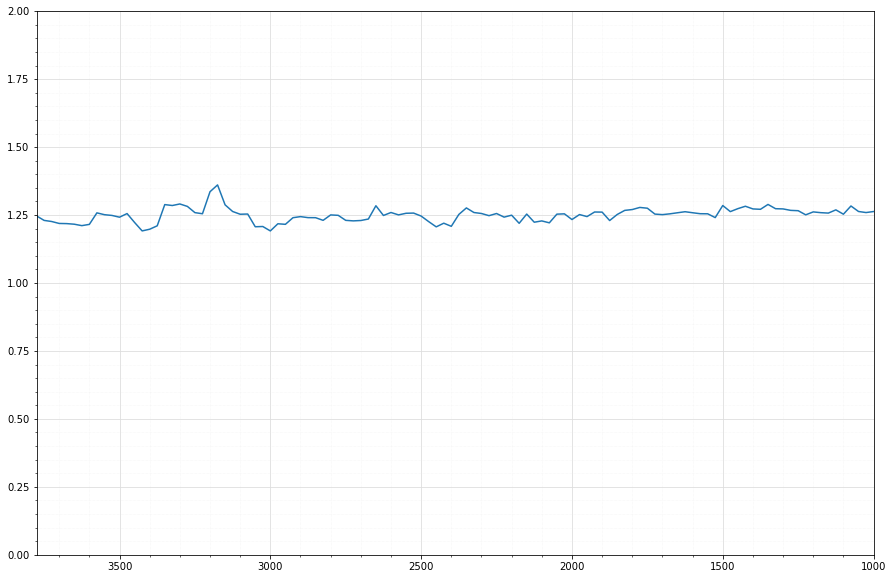

In [722]:
plot_bloodlust_increase("No Filler", ["twist", "cs", "cons", "exo"], True, 600, melee_haste, spell_haste)